In [1]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

# Define the structure
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.dof_indices = None  # [u, v]

class Beam:
    def __init__(self, node1_idx, node2_idx, E, A, I, c):
        self.node1_idx = node1_idx
        self.node2_idx = node2_idx
        self.E = E  # Young's modulus (Pa)
        self.A = A  # Cross-sectional area (m^2)
        self.I = I  # Moment of inertia (m^4)
        self.c = c  # Distance from neutral axis to extreme fiber (m)
        self.length = None
        self.angle = None
        self.dof_indices = None  # [u1, v1, theta1, u2, v2, theta2]

class Connection:
    def __init__(self, beam1_idx, beam2_idx, conn_type, k_theta=None):
        self.beam1_idx = beam1_idx
        self.beam2_idx = beam2_idx
        self.conn_type = conn_type  # 'rigid' or 'spring'
        self.k_theta = k_theta if conn_type == 'spring' else None

class UnionFind:
    def __init__(self, size):
        self.parent = list(range(size))
        self.rank = [0] * size

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        px, py = self.find(x), self.find(y)
        if px == py:
            return
        if self.rank[px] < self.rank[py]:
            px, py = py, px
        self.parent[py] = px
        if self.rank[px] == self.rank[py]:
            self.rank[px] += 1

def compute_beam_properties(nodes, beam):
    n1, n2 = nodes[beam.node1_idx], nodes[beam.node2_idx]
    dx = n2.x - n1.x
    dy = n2.y - n1.y
    beam.length = np.sqrt(dx**2 + dy**2)
    beam.angle = np.arctan2(dy, dx)

def local_stiffness_matrix(beam):
    E, A, I, L = beam.E, beam.A, beam.I, beam.length
    k_local = np.zeros((6, 6))
    ea_l = E * A / L
    k_local[0, 0] = ea_l
    k_local[0, 3] = -ea_l
    k_local[3, 0] = -ea_l
    k_local[3, 3] = ea_l
    ei_l3 = E * I / L**3
    ei_l2 = E * I / L**2
    ei_l = E * I / L
    k_local[1, 1] = 12 * ei_l3
    k_local[1, 2] = 6 * ei_l2
    k_local[1, 4] = -12 * ei_l3
    k_local[1, 5] = 6 * ei_l2
    k_local[2, 1] = 6 * ei_l2
    k_local[2, 2] = 4 * ei_l
    k_local[2, 4] = -6 * ei_l2
    k_local[2, 5] = 2 * ei_l
    k_local[4, 1] = -12 * ei_l3
    k_local[4, 2] = -6 * ei_l2
    k_local[4, 4] = 12 * ei_l3
    k_local[4, 5] = -6 * ei_l2
    k_local[5, 1] = 6 * ei_l2
    k_local[5, 2] = 2 * ei_l
    k_local[5, 4] = -6 * ei_l2
    k_local[5, 5] = 4 * ei_l
    return k_local

def transformation_matrix(beam):
    c = np.cos(beam.angle)
    s = np.sin(beam.angle)
    R = np.array([[c, s, 0], [-s, c, 0], [0, 0, 1]])
    T = np.zeros((6, 6))
    T[0:3, 0:3] = R
    T[3:6, 3:6] = R
    return T

def equivalent_nodal_loads(beam, q):
    L = beam.length
    f_local = np.array([0, -q * L / 2, -q * L**2 / 12, 0, -q * L / 2, q * L**2 / 12])
    return f_local

def assign_dofs(nodes, beams, connections):
    beams_at_node = [[] for _ in nodes]
    for b_idx, beam in enumerate(beams):
        beams_at_node[beam.node1_idx].append(b_idx)
        beams_at_node[beam.node2_idx].append(b_idx)

    total_dofs = 0
    theta_dof_map = {}

    for n_idx, node in enumerate(nodes):
        node.dof_indices = [total_dofs, total_dofs + 1]  # u, v
        total_dofs += 2

        if not beams_at_node[n_idx]:
            continue
        beam_indices = beams_at_node[n_idx]
        uf = UnionFind(len(beams))
        conn_at_node = [c for c in connections if beams[c.beam1_idx].node1_idx == n_idx or beams[c.beam1_idx].node2_idx == n_idx]
        for conn in conn_at_node:
            b1, b2 = conn.beam1_idx, conn.beam2_idx
            if conn.conn_type == 'rigid' and (b1 in beam_indices and b2 in beam_indices):
                uf.union(b1, b2)

        components = {}
        for b_idx in beam_indices:
            root = uf.find(b_idx)
            if root not in components:
                components[root] = total_dofs
                total_dofs += 1
            theta_dof_map[(n_idx, b_idx)] = components[root]

    for beam in beams:
        dof1 = nodes[beam.node1_idx].dof_indices + [theta_dof_map[(beam.node1_idx, beams.index(beam))]]
        dof2 = nodes[beam.node2_idx].dof_indices + [theta_dof_map[(beam.node2_idx, beams.index(beam))]]
        beam.dof_indices = dof1 + dof2

    return total_dofs, beams_at_node

def assemble_system(nodes, beams, connections, loads, boundary_conditions):
    total_dofs, beams_at_node = assign_dofs(nodes, beams, connections)
    K = lil_matrix((total_dofs, total_dofs))
    F = np.zeros(total_dofs)

    for beam in beams:
        compute_beam_properties(nodes, beam)
        k_local = local_stiffness_matrix(beam)
        T = transformation_matrix(beam)
        k_global = T.T @ k_local @ T
        dofs = beam.dof_indices
        for i in range(6):
            for j in range(6):
                K[dofs[i], dofs[j]] += k_global[i, j]

    for conn in connections:
        if conn.conn_type == 'spring':
            b1, b2 = beams[conn.beam1_idx], beams[conn.beam2_idx]
            common_node = set([b1.node1_idx, b1.node2_idx]) & set([b2.node1_idx, b2.node2_idx])
            if common_node:
                n_idx = common_node.pop()
                theta1 = b1.dof_indices[2 if b1.node1_idx == n_idx else 5]
                theta2 = b2.dof_indices[2 if b2.node1_idx == n_idx else 5]
                k_theta = conn.k_theta
                K[theta1, theta1] += k_theta
                K[theta2, theta2] += k_theta
                K[theta1, theta2] -= k_theta
                K[theta2, theta1] -= k_theta

    for load in loads:
        if 'node_idx' in load:
            n_idx = load['node_idx']
            if 'Fx' in load:
                F[nodes[n_idx].dof_indices[0]] += load['Fx']
            if 'Fy' in load:
                F[nodes[n_idx].dof_indices[1]] += load['Fy']
            if 'M' in load:
                b_idx = beams_at_node[n_idx][0]
                theta_dof = beams[b_idx].dof_indices[2 if beams[b_idx].node1_idx == n_idx else 5]
                F[theta_dof] += load['M']
        elif 'beam_idx' in load:
            beam = beams[load['beam_idx']]
            q = load['q']
            f_local = equivalent_nodal_loads(beam, q)
            T = transformation_matrix(beam)
            f_global = T.T @ f_local
            dofs = beam.dof_indices
            for i in range(6):
                F[dofs[i]] += f_global[i]

    for bc in boundary_conditions:
        n_idx = bc['node_idx']
        for dof_type, value in bc.items():
            if dof_type == 'node_idx':
                continue
            idx = {'u': 0, 'v': 1, 'theta': 2}[dof_type]
            if idx < 2:
                dof = nodes[n_idx].dof_indices[idx]
            else:
                if beams_at_node[n_idx]:
                    b_idx = beams_at_node[n_idx][0]
                    dof = beams[b_idx].dof_indices[2 if beams[b_idx].node1_idx == n_idx else 5]
                else:
                    continue
            K[dof, :] = 0
            K[:, dof] = 0
            K[dof, dof] = 1
            F[dof] = value

    return K, F

def compute_stresses(beams, U):
    stresses = []
    for beam in beams:
        dofs = beam.dof_indices
        U_e = U[dofs]
        T = transformation_matrix(beam)
        u_local = T @ U_e
        N = beam.E * beam.A / beam.length * (u_local[3] - u_local[0])
        v1, theta1, v2, theta2 = u_local[1], u_local[2], u_local[4], u_local[5]
        L = beam.length
        d2v_dx2_left = (-6/L**2) * v1 + (-4/L**2) * theta1 + (6/L**2) * v2 + (-2/L**2) * theta2
        d2v_dx2_right = (6/L**2) * v1 + (2/L**2) * theta1 + (-6/L**2) * v2 + (4/L**2) * theta2
        M_left = -beam.E * beam.I * d2v_dx2_left
        M_right = -beam.E * beam.I * d2v_dx2_right
        sigma_left_top = N / beam.A - M_left * beam.c / beam.I
        sigma_left_bottom = N / beam.A + M_left * beam.c / beam.I
        sigma_right_top = N / beam.A - M_right * beam.c / beam.I
        sigma_right_bottom = N / beam.A + M_right * beam.c / beam.I
        stresses.append({
            'beam_idx': beams.index(beam),
            'left': {'top': sigma_left_top, 'bottom': sigma_left_bottom},
            'right': {'top': sigma_right_top, 'bottom': sigma_right_bottom}
        })
    return stresses

def main():
    nodes = [Node(0, 0), Node(1, 0), Node(2, 0)]
    beams = [
        Beam(0, 1, 210e9, 0.01, 1e-4, 0.05),
        Beam(1, 2, 210e9, 0.01, 1e-4, 0.05)
    ]
    connections = [Connection(0, 1, 'rigid')]
    loads = [{'beam_idx': 0, 'q': -10000,
              'beam_idx': 1, 'q': -10000}]
    boundary_conditions = [
        {'node_idx': 0, 'u': 0, 'v': 0, 'theta': 0},
        {'node_idx': 2, 'u': 0, 'v': 0, 'theta': 0}
    ]

    K, F = assemble_system(nodes, beams, connections, loads, boundary_conditions)
    K = K.tocsr()
    U = spsolve(K, F)
    print(U)
    stresses = compute_stresses(beams, U)

    for s in stresses:
        print(f"Beam {s['beam_idx']}:")
        print(f"  Left - Top: {s['left']['top']:.2f} Pa, Bottom: {s['left']['bottom']:.2f} Pa")
        print(f"  Right - Top: {s['right']['top']:.2f} Pa, Bottom: {s['right']['bottom']:.2f} Pa")

if __name__ == "__main__":
    main()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.92063492e-06 4.96031746e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Beam 0:
  Left - Top: 520833.33 Pa, Bottom: -520833.33 Pa
  Right - Top: -416666.67 Pa, Bottom: 416666.67 Pa
Beam 1:
  Left - Top: -833333.33 Pa, Bottom: 833333.33 Pa
  Right - Top: 729166.67 Pa, Bottom: -729166.67 Pa


In [2]:
# main.py

import numpy as np
from itertools import combinations

from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer

def main():
    """
    Example of the rigid arch structure, now including Poisson's ratio
    in the material definition.
    """
    nodes = [
        Node(0, 0, 0),    #0
        Node(0, 1, 0),    #1
        Node(0.5, 1, 0),  #2
        Node(1, 1, 0),    #3
        Node(1, 0, 0),    #4
    ]

    # --- Material and Section Properties ---
    E_steel = 200e9
    nu_steel = 0.3 # Define Poisson's ratio for the material
    rho_steel = 7850  # Density of steel in kg/m^3

    A = 0.1 * 0.2
    Iz = (0.2 * 0.1**3) / 12; Iy = (0.1 * 0.2**3) / 12
    a, b = max(0.1, 0.2), min(0.1, 0.2)
    J = a * b**3 * (1/3 - 0.21 * (b/a) * (1 - (b**4)/(12*a**4)))
    cy, cz = 0.1 / 2, 0.2 / 2

    beams = [
        Beam(0, 1, E_steel, nu_steel, rho_steel, A, Iy, Iz, J, cy, cz, ref_vector=np.array([0, 0, 1])),
        Beam(1, 2, E_steel, nu_steel, rho_steel, A, Iy, Iz, J, cy, cz, ref_vector=np.array([0, 0, 1])),
        Beam(2, 3, E_steel, nu_steel, rho_steel, A, Iy, Iz, J, cy, cz, ref_vector=np.array([0, 0, 1])),
        Beam(3, 4, E_steel, nu_steel, rho_steel, A, Iy, Iz, J, cy, cz, ref_vector=np.array([0, 0, 1])),
    ]

    connections = [
        Connection(0, 1, 'rigid'),
        Connection(1, 2, 'rigid'),
        Connection(2, 3, 'rigid')
    ]

    loads = [{'node_idx': 2, 'Fy': -5000}]
    boundary_conditions = [
        {'node_idx': 0, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0},
        {'node_idx': 4, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0}
    ]

    # --- Create and run the analysis ---
    analyzer = FrameAnalyzer(nodes, beams, connections)

    if analyzer.solve(loads, boundary_conditions):
        print("--- Analysis Results (Local Vectorial Sign Convention) ---\n")
        results = analyzer.get_results()

        for r in results:
            b_idx, n1_idx, n2_idx = r['beam_idx'], beams[r['beam_idx']].node1_idx, beams[r['beam_idx']].node2_idx

            print(f"--- Beam {b_idx} (Nodes {n1_idx} to {n2_idx}) ---")

            n1 = r['node1']
            print(f"  End A (at Node {n1_idx}):")
            print(f"    Axial Force: {n1['N']:.2f} N, Stress: {n1['sigma_axial']/1e6:.2f} MPa")
            print(f"    Local Shear: Vy={n1['Vy']:.2f} N, Vz={n1['Vz']:.2f} N")
            print(f"    Local Moment: Mx={n1['Mx']:.2f} Nm, My={n1['My']:.2f} Nm, Mz={n1['Mz']:.2f} Nm")
            s1 = n1['stresses']
            stress_str1 = (f"y+/z+: {s1['y+z+']/1e6:.2f}, y+/z-: {s1['y+z-']/1e6:.2f}, "
                           f"y-/z+: {s1['y-z+']/1e6:.2f}, y-/z-: {s1['y-z-']/1e6:.2f} MPa")
            print(f"    Local Corner Stresses ({stress_str1})")


            n2 = r['node2']
            print(f"  End B (at Node {n2_idx}):")
            print(f"    Axial Force: {n2['N']:.2f} N, Stress: {n2['sigma_axial']/1e6:.2f} MPa")
            print(f"    Local Shear: Vy={n2['Vy']:.2f} N, Vz={n2['Vz']:.2f} N")
            print(f"    Local Moment: Mx={n2['Mx']:.2f} Nm, My={n2['My']:.2f} Nm, Mz={n2['Mz']:.2f} Nm")
            s2 = n2['stresses']
            stress_str2 = (f"y+/z+: {s2['y+z+']/1e6:.2f}, y+/z-: {s2['y+z-']/1e6:.2f}, "
                           f"y-/z+: {s2['y-z+']/1e6:.2f}, y-/z-: {s2['y-z-']/1e6:.2f} MPa")
            print(f"    Local Corner Stresses ({stress_str2})")
            print("-" * 25 + "\n")

    else:
        print("Analysis failed.")

if __name__ == "__main__":
    main()

--- Analysis Results (Local Vectorial Sign Convention) ---

--- Beam 0 (Nodes 0 to 1) ---
  End A (at Node 0):
    Axial Force: -2500.00 N, Stress: -0.13 MPa
    Local Shear: Vy=-623.44 N, Vz=0.00 N
    Local Moment: Mx=0.00 Nm, My=0.00 Nm, Mz=-207.29 Nm
    Local Corner Stresses (y+/z+: -0.75, y+/z-: -0.75, y-/z+: 0.50, y-/z-: 0.50 MPa)
  End B (at Node 1):
    Axial Force: -2500.00 N, Stress: -0.13 MPa
    Local Shear: Vy=-623.44 N, Vz=-0.00 N
    Local Moment: Mx=-0.00 Nm, My=-0.00 Nm, Mz=416.15 Nm
    Local Corner Stresses (y+/z+: -1.37, y+/z-: -1.37, y-/z+: 1.12, y-/z-: 1.12 MPa)
-------------------------

--- Beam 1 (Nodes 1 to 2) ---
  End A (at Node 1):
    Axial Force: -623.44 N, Stress: -0.03 MPa
    Local Shear: Vy=2500.00 N, Vz=0.00 N
    Local Moment: Mx=0.00 Nm, My=0.00 Nm, Mz=416.15 Nm
    Local Corner Stresses (y+/z+: 1.22, y+/z-: 1.22, y-/z+: -1.28, y-/z-: -1.28 MPa)
  End B (at Node 2):
    Axial Force: -623.44 N, Stress: -0.03 MPa
    Local Shear: Vy=2500.00 N, Vz=-0

--- Setting up Manually Defined 3D Building Frame ---
Defining nodes manually...
Defining beams and columns manually...
Defining rigid connections manually...
Model generated: 18 nodes, 26 beams, 68 rigid connections.
Applying uniform gravity load of 20.0 kN/m to ROOF beams only...
Applying fixed boundary conditions to all column bases...

--- Starting Analysis ---
Analysis successful.

--- Generating Visualizations ---
Showing axial force plot...


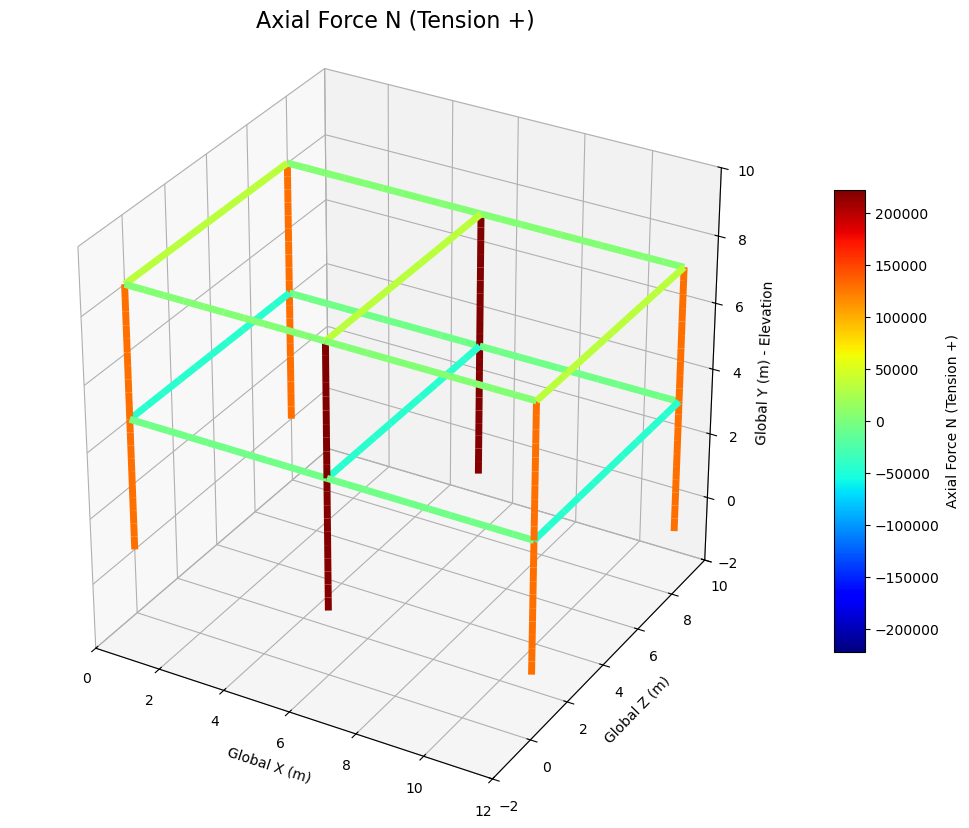

Showing bending moment (Mz) plot...


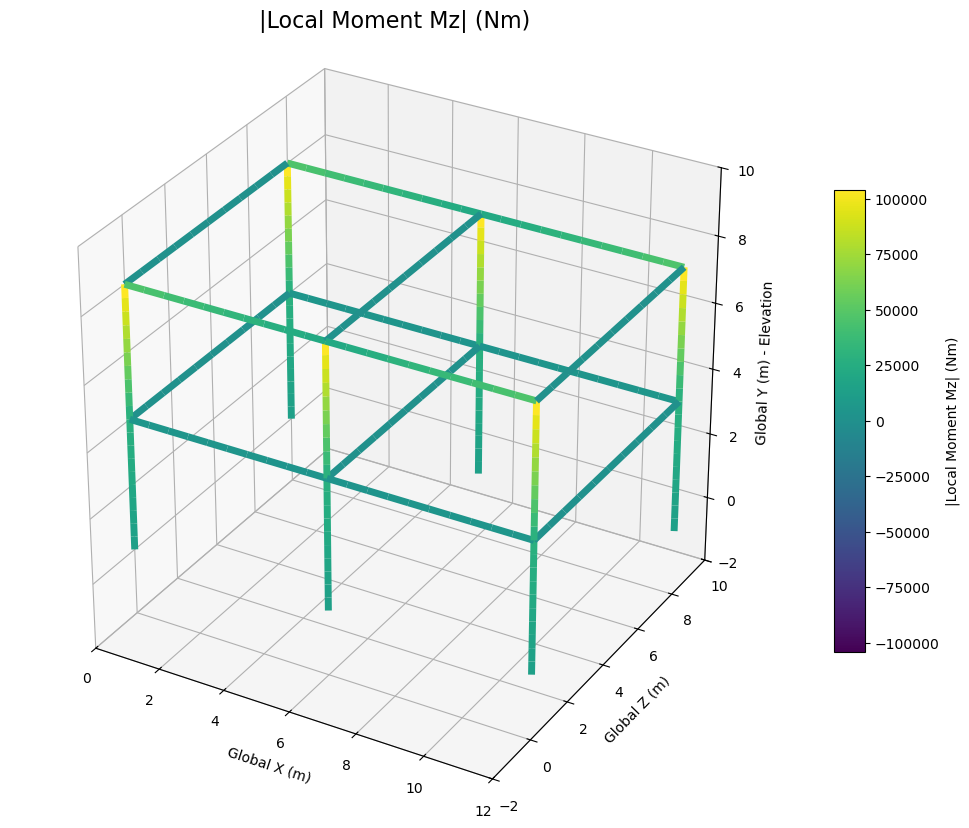

In [3]:
# main_manual_structure.py

import numpy as np
from itertools import combinations

# Import the refactored classes
from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer
from visualizer import Visualizer

"""
Defines and analyzes a 3D building frame by manually specifying every
node, beam, and connection to ensure a correct and stable model.
"""
print("--- Setting up Manually Defined 3D Building Frame ---")

# 1. --- Define Structure Geometry ---
num_stories = 2
story_height = 4.0
bay_widths_x = [6.0, 6.0]
bay_widths_z = [8.0]

# 2. --- Define Material and Section Properties ---
E_steel = 200e9
nu_steel = 0.3
rho_steel = 7850  # Density of steel in kg/m^3
col_props = {'A': 0.0123, 'Iz': 222e-6, 'Iy': 72.4e-6, 'J': 800e-9, 'cy': 0.155, 'cz': 0.1525, 'nu': nu_steel, 'rho': rho_steel}
beam_props = {'A': 0.0104, 'Iz': 370e-6, 'Iy': 19.9e-6, 'J': 650e-9, 'cy': 0.2285, 'cz': 0.095, 'nu': nu_steel, 'rho': rho_steel}

# 3. --- Manually Define the Structure ---
print("Defining nodes manually...")
nodes = [
    # Ground Floor (Y=0)
    Node(0,  0, 0),  # Node 0
    Node(6,  0, 0),  # Node 1
    Node(12, 0, 0),  # Node 2
    Node(0,  0, 8),  # Node 3
    Node(6,  0, 8),  # Node 4
    Node(12, 0, 8),  # Node 5
    # First Floor (Y=4)
    Node(0,  4, 0),  # Node 6
    Node(6,  4, 0),  # Node 7
    Node(12, 4, 0),  # Node 8
    Node(0,  4, 8),  # Node 9
    Node(6,  4, 8),  # Node 10
    Node(12, 4, 8),  # Node 11
    # Roof Level (Y=8)
    Node(0,  8, 0),  # Node 12
    Node(6,  8, 0),  # Node 13
    Node(12, 8, 0),  # Node 14
    Node(0,  8, 8),  # Node 15
    Node(6,  8, 8),  # Node 16
    Node(12, 8, 8),  # Node 17
]

print("Defining beams and columns manually...")
beams = [
    # Columns Story 1
    Beam(0, 6,  E_steel, **col_props, ref_vector=np.array([1,0,0])), # Beam 0
    Beam(1, 7,  E_steel, **col_props, ref_vector=np.array([1,0,0])), # Beam 1
    Beam(2, 8,  E_steel, **col_props, ref_vector=np.array([1,0,0])), # Beam 2
    Beam(3, 9,  E_steel, **col_props, ref_vector=np.array([1,0,0])), # Beam 3
    Beam(4, 10, E_steel, **col_props, ref_vector=np.array([1,0,0])), # Beam 4
    Beam(5, 11, E_steel, **col_props, ref_vector=np.array([1,0,0])), # Beam 5
    # Columns Story 2
    Beam(6, 12, E_steel, **col_props, ref_vector=np.array([1,0,0])), # Beam 6
    Beam(7, 13, E_steel, **col_props, ref_vector=np.array([1,0,0])), # Beam 7
    Beam(8, 14, E_steel, **col_props, ref_vector=np.array([1,0,0])), # Beam 8
    Beam(9, 15, E_steel, **col_props, ref_vector=np.array([1,0,0])), # Beam 9
    Beam(10,16, E_steel, **col_props, ref_vector=np.array([1,0,0])), # Beam 10
    Beam(11,17, E_steel, **col_props, ref_vector=np.array([1,0,0])), # Beam 11
    # Beams Floor 1 (Y=4)
    Beam(6, 7,  E_steel, **beam_props), # Beam 12 (X-dir)
    Beam(7, 8,  E_steel, **beam_props), # Beam 13 (X-dir)
    Beam(9, 10, E_steel, **beam_props), # Beam 14 (X-dir)
    Beam(10,11, E_steel, **beam_props), # Beam 15 (X-dir)
    Beam(6, 9,  E_steel, **beam_props), # Beam 16 (Z-dir)
    Beam(7, 10, E_steel, **beam_props), # Beam 17 (Z-dir)
    Beam(8, 11, E_steel, **beam_props), # Beam 18 (Z-dir)
    # Beams Roof (Y=8)
    Beam(12,13, E_steel, **beam_props), # Beam 19 (X-dir)
    Beam(13,14, E_steel, **beam_props), # Beam 20 (X-dir)
    Beam(15,16, E_steel, **beam_props), # Beam 21 (X-dir)
    Beam(16,17, E_steel, **beam_props), # Beam 22 (X-dir)
    Beam(12,15, E_steel, **beam_props), # Beam 23 (Z-dir)
    Beam(13,16, E_steel, **beam_props), # Beam 24 (Z-dir)
    Beam(14,17, E_steel, **beam_props), # Beam 25 (Z-dir)
]

print("Defining rigid connections manually...")
beams_at_node = [
    [0], [1], [2], [3], [4], [5],  # Ground nodes
    [0, 6, 12, 16],                # Node 6
    [1, 7, 12, 13, 17],            # Node 7
    [2, 8, 13, 18],                # Node 8
    [3, 9, 14, 16],                # Node 9
    [4, 10, 14, 15, 17],           # Node 10
    [5, 11, 15, 18],               # Node 11
    [6, 19, 23],                   # Node 12
    [7, 19, 20, 24],               # Node 13
    [8, 20, 25],                   # Node 14
    [9, 21, 23],                   # Node 15
    [10, 21, 22, 24],              # Node 16
    [11, 22, 25],                  # Node 17
]
connections = []
for node_beams_list in beams_at_node:
    if len(node_beams_list) > 1:
        for b1, b2 in combinations(node_beams_list, 2):
            connections.append(Connection(b1, b2, 'rigid'))

print(f"Model generated: {len(nodes)} nodes, {len(beams)} beams, {len(connections)} rigid connections.")

# 4. --- Define Loads and Boundary Conditions ---
loads = []
q_gravity_magnitude = 20e3
global_load_direction = np.array([0, -1, 0])

print(f"Applying uniform gravity load of {q_gravity_magnitude / 1000} kN/m to ROOF beams only...")
temp_analyzer = FrameAnalyzer(nodes, beams, connections)

for beam_idx, beam in enumerate(beams):
    n1 = nodes[beam.node1_idx]
    n2 = nodes[beam.node2_idx]

    is_roof_beam = abs(n1.y - (num_stories * story_height)) < 1e-6 and abs(n2.y - n1.y) < 1e-6

    if is_roof_beam:
        temp_analyzer._compute_beam_properties(beam)
        local_load_direction = beam.rotation_matrix @ global_load_direction
        qy_load = q_gravity_magnitude * local_load_direction[1]
        qz_load = q_gravity_magnitude * local_load_direction[2]
        loads.append({'beam_idx': beam_idx, 'qy': qy_load, 'qz': qz_load})

boundary_conditions = []
print("Applying fixed boundary conditions to all column bases...")
for node_idx in range(6): # Nodes 0 through 5 are at the base
    boundary_conditions.append({'node_idx': node_idx, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0})

# 5. --- Run the Analysis ---
print("\n--- Starting Analysis ---")
analyzer = FrameAnalyzer(nodes, beams, connections)

if analyzer.solve(loads, boundary_conditions):
    print("Analysis successful.")

    # 6. --- VISUALIZATION ---
    print("\n--- Generating Visualizations ---")
    visualizer = Visualizer(analyzer)

    print("Showing axial force plot...")
    visualizer.plot(result_type='axial_force')
    print("Showing bending moment (Mz) plot...")
    visualizer.plot(result_type='moment_z')

else:
    print("Analysis failed.")

--- Setting up a SIMPLE 1-Story Test Frame ---
Defining nodes manually...
Defining beams and columns manually...
Defining rigid connections manually...
Model generated: 8 nodes, 8 beams, 12 rigid connections.

--- Starting Analysis ---
Analysis successful.

--- Key Results ---
Beam 0 (Column) Axial Force: -10000.00 N
Beam 1 (Column) Axial Force: -10000.00 N
Beam 2 (Column) Axial Force: -10000.00 N
Beam 3 (Column) Axial Force: -10000.00 N

Generating visualization...


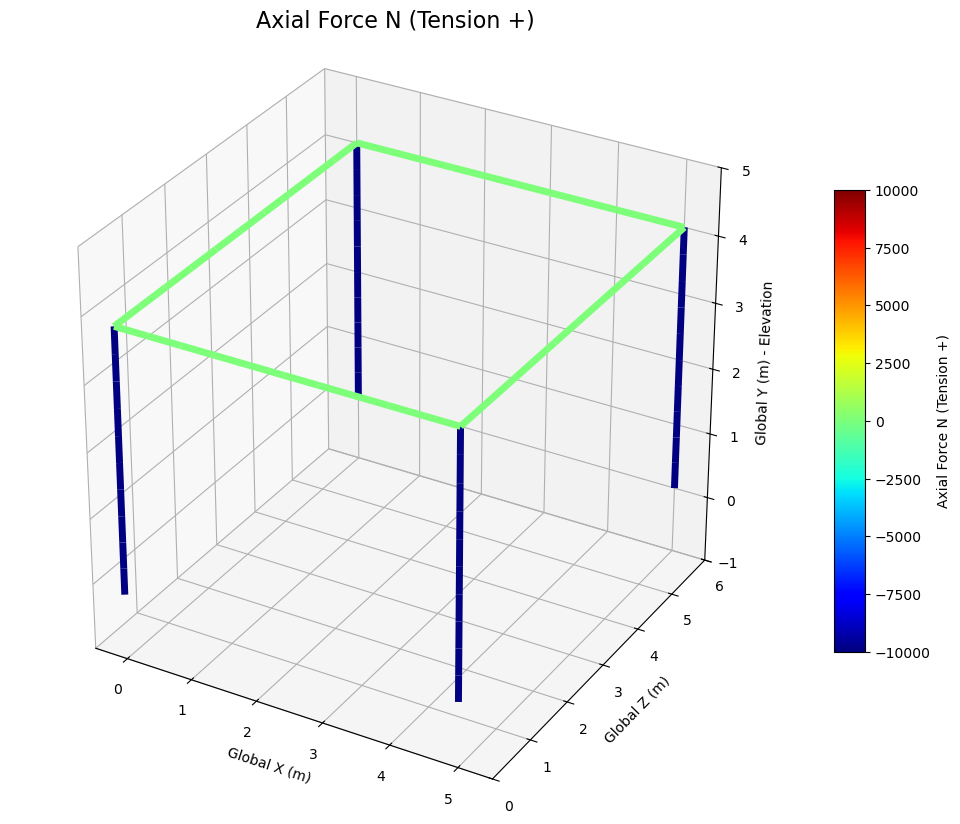

In [4]:
# main_simple_test.py

import numpy as np
from itertools import combinations

# Import the refactored classes
from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer
from visualizer import Visualizer

"""
Analyzes a simple, manually-defined one-story building to provide a clear
and verifiable test case for the solver.
"""
print("--- Setting up a SIMPLE 1-Story Test Frame ---")

# 1. --- Define Material and Section Properties ---
E_steel = 200e9
nu_steel = 0.3
rho_steel = 7850  # Density of steel in kg/m^3
# Use the same properties for all members for simplicity
props = {'A': 0.0123, 'Iz': 222e-6, 'Iy': 72.4e-6, 'J': 800e-9, 'cy': 0.155, 'cz': 0.1525, 'nu': nu_steel, 'rho': rho_steel}

# 2. --- Manually Define the Structure ---
print("Defining nodes manually...")
nodes = [
    # Ground Floor (Y=0)
    Node(0, 0, 0),  # Node 0
    Node(5, 0, 0),  # Node 1
    Node(0, 0, 6),  # Node 2
    Node(5, 0, 6),  # Node 3
    # Roof Level (Y=4)
    Node(0, 4, 0),  # Node 4
    Node(5, 4, 0),  # Node 5
    Node(0, 4, 6),  # Node 6
    Node(5, 4, 6),  # Node 7
]

print("Defining beams and columns manually...")
beams = [
    # 4 Columns
    Beam(0, 4, E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 0
    Beam(1, 5, E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 1
    Beam(2, 6, E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 2
    Beam(3, 7, E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 3
    # 4 Roof Beams
    Beam(4, 5, E_steel, **props), # Beam 4 (X-dir)
    Beam(5, 7, E_steel, **props), # Beam 5 (Z-dir)
    Beam(6, 7, E_steel, **props), # Beam 6 (X-dir)
    Beam(4, 6, E_steel, **props), # Beam 7 (Z-dir)
]

print("Defining rigid connections manually...")
# This list maps a node index to the list of beam indices that connect to it.
beams_at_node = [
    [0], [1], [2], [3], # Ground nodes
    [0, 4, 7],          # Node 4
    [1, 4, 5],          # Node 5
    [2, 6, 7],          # Node 6
    [3, 5, 6],          # Node 7
]
connections = []
for node_beams_list in beams_at_node:
    if len(node_beams_list) > 1:
        for b1, b2 in combinations(node_beams_list, 2):
            connections.append(Connection(b1, b2, 'rigid'))

print(f"Model generated: {len(nodes)} nodes, {len(beams)} beams, {len(connections)} rigid connections.")

# 3. --- Define Loads and Boundary Conditions ---
loads = [
    {'node_idx': 4, 'Fy': -10000}, # 10 kN point load down
    {'node_idx': 5, 'Fy': -10000},
    {'node_idx': 6, 'Fy': -10000},
    {'node_idx': 7, 'Fy': -10000},
]

boundary_conditions = [
    {'node_idx': 0, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0},
    {'node_idx': 1, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0},
    {'node_idx': 2, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0},
    {'node_idx': 3, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0},
]

# 4. --- Run the Analysis ---
print("\n--- Starting Analysis ---")
analyzer = FrameAnalyzer(nodes, beams, connections)

if analyzer.solve(loads, boundary_conditions):
    print("Analysis successful.")

    # 5. --- Display & Visualize Results ---
    print("\n--- Key Results ---")
    results = analyzer.get_results()

    # Print the axial force for each column
    for i in range(4):
        axial_force_N = results[i]['node1']['N']
        print(f"Beam {i} (Column) Axial Force: {axial_force_N:.2f} N")

    visualizer = Visualizer(analyzer)
    print("\nGenerating visualization...")
    visualizer.plot(result_type='axial_force')

else:
    print("Analysis failed.")

--- Setting up a 1-Story, 6-Column Test Frame ---
Defining nodes manually...
Defining beams and columns manually...
Defining rigid connections manually...
Model generated: 12 nodes, 13 beams, 24 rigid connections.

--- Starting Analysis ---
Analysis successful.

--- Key Results ---
Beam 0 (Column) Axial Force: -10000.00 N
Beam 1 (Column) Axial Force: -10000.00 N
Beam 2 (Column) Axial Force: -10000.00 N
Beam 3 (Column) Axial Force: -10000.00 N
Beam 4 (Column) Axial Force: -10000.00 N
Beam 5 (Column) Axial Force: -10000.00 N

Generating visualization...


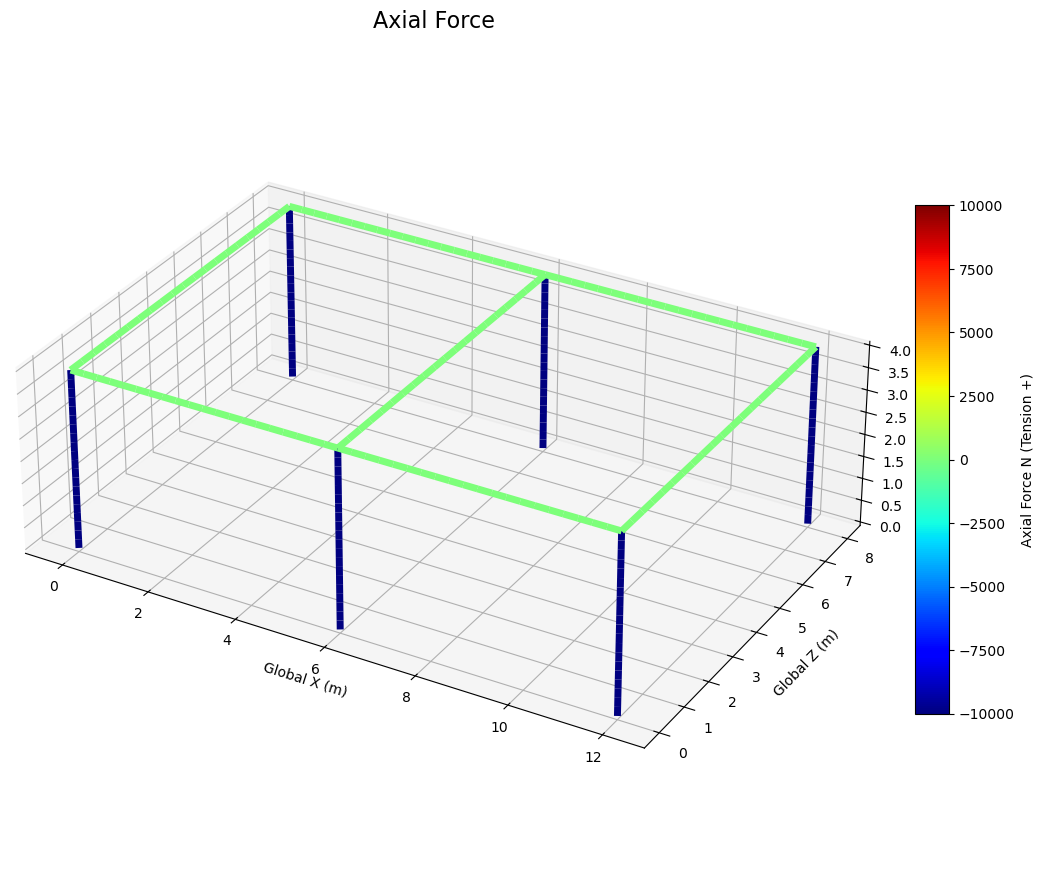

In [6]:
# main_six_column_test.py

import numpy as np
from itertools import combinations

# Import the refactored classes
from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer
from visualizer import Visualizer

"""
Analyzes a manually-defined one-story building with six columns.
"""
print("--- Setting up a 1-Story, 6-Column Test Frame ---")

# 1. --- Define Material and Section Properties ---
E_steel = 200e9
nu_steel = 0.3
rho_steel = 7850  # Density of steel in kg/m^3
# Using the same properties for all members for simplicity
props = {'A': 0.0123, 'Iz': 222e-6, 'Iy': 72.4e-6, 'J': 800e-9, 'cy': 0.155, 'cz': 0.1525, 'nu': nu_steel, 'rho': rho_steel}

# 2. --- Manually Define the Structure ---
print("Defining nodes manually...")
nodes = [
    # Ground Floor (Y=0) - A 3x2 grid
    Node(0,  0, 0),  # Node 0
    Node(6,  0, 0),  # Node 1
    Node(12, 0, 0),  # Node 2
    Node(0,  0, 8),  # Node 3
    Node(6,  0, 8),  # Node 4
    Node(12, 0, 8),  # Node 5
    # Roof Level (Y=4)
    Node(0,  4, 0),  # Node 6
    Node(6,  4, 0),  # Node 7
    Node(12, 4, 0),  # Node 8
    Node(0,  4, 8),  # Node 9
    Node(6,  4, 8),  # Node 10
    Node(12, 4, 8),  # Node 11
]

print("Defining beams and columns manually...")
beams = [
    # 6 Columns
    Beam(0, 6,  E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 0
    Beam(1, 7,  E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 1
    Beam(2, 8,  E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 2
    Beam(3, 9,  E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 3
    Beam(4, 10, E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 4
    Beam(5, 11, E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 5
    # 7 Roof Beams
    Beam(6, 7,  E_steel, **props), # Beam 6 (X-dir)
    Beam(7, 8,  E_steel, **props), # Beam 7 (X-dir)
    Beam(9, 10, E_steel, **props), # Beam 8 (X-dir)
    Beam(10,11, E_steel, **props), # Beam 9 (X-dir)
    Beam(6, 9,  E_steel, **props), # Beam 10 (Z-dir)
    Beam(7, 10, E_steel, **props), # Beam 11 (Z-dir)
    Beam(8, 11, E_steel, **props), # Beam 12 (Z-dir)
]

print("Defining rigid connections manually...")
# This list maps a node index to the list of beam indices that connect to it.
beams_at_node = [
    [0], [1], [2], [3], [4], [5], # Ground nodes
    [0, 6, 10],                  # Node 6
    [1, 6, 7, 11],               # Node 7
    [2, 7, 12],                  # Node 8
    [3, 8, 10],                  # Node 9
    [4, 8, 9, 11],               # Node 10
    [5, 9, 12],                  # Node 11
]
connections = []
for node_beams_list in beams_at_node:
    if len(node_beams_list) > 1:
        for b1, b2 in combinations(node_beams_list, 2):
            connections.append(Connection(b1, b2, 'rigid'))

print(f"Model generated: {len(nodes)} nodes, {len(beams)} beams, {len(connections)} rigid connections.")

# 3. --- Define Loads and Boundary Conditions ---
loads = [
    {'node_idx': 6, 'Fy': -10000}, # 10 kN point load down on each roof node
    {'node_idx': 7, 'Fy': -10000},
    {'node_idx': 8, 'Fy': -10000},
    {'node_idx': 9, 'Fy': -10000},
    {'node_idx': 10,'Fy': -10000},
    {'node_idx': 11,'Fy': -10000},
]

boundary_conditions = []
for i in range(6): # Nodes 0 through 5 are at the base
    boundary_conditions.append({'node_idx': i, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0})

# 4. --- Run the Analysis ---
print("\n--- Starting Analysis ---")
analyzer = FrameAnalyzer(nodes, beams, connections)

if analyzer.solve(loads, boundary_conditions):
    print("Analysis successful.")

    # 5. --- Display & Visualize Results ---
    print("\n--- Key Results ---")
    results = analyzer.get_results()

    # Print the axial force for each of the 6 columns
    for i in range(6):
        axial_force_N = results[i]['node1']['N']
        print(f"Beam {i} (Column) Axial Force: {axial_force_N:.2f} N")

    visualizer = Visualizer(analyzer)
    print("\nGenerating visualization...")
    visualizer.plot(result_type='axial_force')

else:
    print("Analysis failed.")

--- Setting up a 2-Story, 6-Column Test Frame ---
Defining nodes manually...
Defining beams and columns manually...
Defining rigid connections manually...
Model generated: 18 nodes, 26 beams, 68 rigid connections.

--- Starting Analysis ---
Analysis successful.

--- Key Results ---

--- Column Axial Forces ---
Beam 0 (Column) Axial Force: -10000.00 N
Beam 1 (Column) Axial Force: -10000.00 N
Beam 2 (Column) Axial Force: -10000.00 N
Beam 3 (Column) Axial Force: -10000.00 N
Beam 4 (Column) Axial Force: -10000.00 N
Beam 5 (Column) Axial Force: -10000.00 N
Beam 6 (Column) Axial Force: -10000.00 N
Beam 7 (Column) Axial Force: -10000.00 N
Beam 8 (Column) Axial Force: -10000.00 N
Beam 9 (Column) Axial Force: -10000.00 N
Beam 10 (Column) Axial Force: -10000.00 N
Beam 11 (Column) Axial Force: -10000.00 N

Generating visualization...


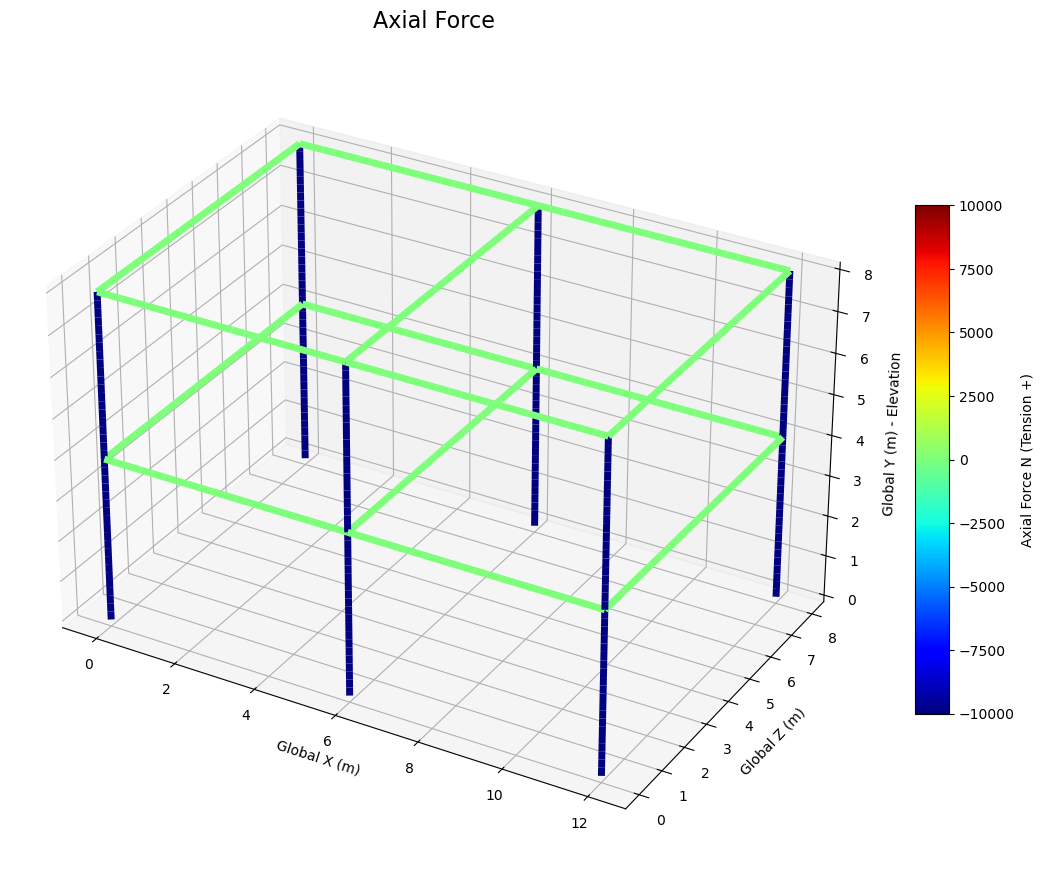

In [7]:
# main_two_story_manual.py

import numpy as np
from itertools import combinations

# Import the refactored classes
from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer
from visualizer import Visualizer

"""
Analyzes a manually-defined TWO-story building with six columns per floor.
"""
print("--- Setting up a 2-Story, 6-Column Test Frame ---")

# 1. --- Define Material and Section Properties ---
E_steel = 200e9
nu_steel = 0.3
rho_steel = 7850  # Density of steel in kg/m^3
# Use the same properties for all members for simplicity
props = {'A': 0.0123, 'Iz': 222e-6, 'Iy': 72.4e-6, 'J': 800e-9, 'cy': 0.155, 'cz': 0.1525, 'nu': nu_steel, 'rho': rho_steel}

# 2. --- Manually Define the Structure ---
print("Defining nodes manually...")
nodes = [
    # Ground Floor (Y=0)
    Node(0,  0, 0),  # Node 0
    Node(6,  0, 0),  # Node 1
    Node(12, 0, 0),  # Node 2
    Node(0,  0, 8),  # Node 3
    Node(6,  0, 8),  # Node 4
    Node(12, 0, 8),  # Node 5
    # First Floor (Y=4)
    Node(0,  4, 0),  # Node 6
    Node(6,  4, 0),  # Node 7
    Node(12, 4, 0),  # Node 8
    Node(0,  4, 8),  # Node 9
    Node(6,  4, 8),  # Node 10
    Node(12, 4, 8),  # Node 11
    # Roof Level (Y=8)
    Node(0,  8, 0),  # Node 12
    Node(6,  8, 0),  # Node 13
    Node(12, 8, 0),  # Node 14
    Node(0,  8, 8),  # Node 15
    Node(6,  8, 8),  # Node 16
    Node(12, 8, 8),  # Node 17
]

print("Defining beams and columns manually...")
beams = [
    # Columns Story 1 (Y=0 to Y=4)
    Beam(0, 6,   E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 0
    Beam(1, 7,   E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 1
    Beam(2, 8,   E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 2
    Beam(3, 9,   E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 3
    Beam(4, 10,  E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 4
    Beam(5, 11,  E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 5
    # Columns Story 2 (Y=4 to Y=8)
    Beam(6, 12,  E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 6
    Beam(7, 13,  E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 7
    Beam(8, 14,  E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 8
    Beam(9, 15,  E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 9
    Beam(10,16,  E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 10
    Beam(11,17,  E_steel, **props, ref_vector=np.array([1,0,0])), # Beam 11
    # Beams First Floor (Y=4)
    Beam(6, 7,   E_steel, **props), # Beam 12 (X-dir)
    Beam(7, 8,   E_steel, **props), # Beam 13 (X-dir)
    Beam(9, 10,  E_steel, **props), # Beam 14 (X-dir)
    Beam(10,11,  E_steel, **props), # Beam 15 (X-dir)
    Beam(6, 9,   E_steel, **props), # Beam 16 (Z-dir)
    Beam(7, 10,  E_steel, **props), # Beam 17 (Z-dir)
    Beam(8, 11,  E_steel, **props), # Beam 18 (Z-dir)
    # Beams Roof (Y=8)
    Beam(12,13,  E_steel, **props), # Beam 19 (X-dir)
    Beam(13,14,  E_steel, **props), # Beam 20 (X-dir)
    Beam(15,16,  E_steel, **props), # Beam 21 (X-dir)
    Beam(16,17,  E_steel, **props), # Beam 22 (X-dir)
    Beam(12,15,  E_steel, **props), # Beam 23 (Z-dir)
    Beam(13,16,  E_steel, **props), # Beam 24 (Z-dir)
    Beam(14,17,  E_steel, **props), # Beam 25 (Z-dir)
]

print("Defining rigid connections manually...")
beams_at_node = [
    [0], [1], [2], [3], [4], [5],    # Ground nodes
    [0, 6, 12, 16],                  # Node 6
    [1, 7, 12, 13, 17],              # Node 7
    [2, 8, 13, 18],                  # Node 8
    [3, 9, 14, 16],                  # Node 9
    [4, 10, 14, 15, 17],             # Node 10
    [5, 11, 15, 18],                 # Node 11
    [6, 19, 23],                     # Node 12
    [7, 19, 20, 24],                 # Node 13
    [8, 20, 25],                     # Node 14
    [9, 21, 23],                     # Node 15
    [10, 21, 22, 24],                # Node 16
    [11, 22, 25],                    # Node 17
]
connections = []
for node_beams_list in beams_at_node:
    if len(node_beams_list) > 1:
        for b1, b2 in combinations(node_beams_list, 2):
            connections.append(Connection(b1, b2, 'rigid'))

print(f"Model generated: {len(nodes)} nodes, {len(beams)} beams, {len(connections)} rigid connections.")

# 3. --- Define Loads and Boundary Conditions ---
loads = [
    # Apply 10kN load to each roof node
    {'node_idx': 12, 'Fy': -10000},
    {'node_idx': 13, 'Fy': -10000},
    {'node_idx': 14, 'Fy': -10000},
    {'node_idx': 15, 'Fy': -10000},
    {'node_idx': 16, 'Fy': -10000},
    {'node_idx': 17, 'Fy': -10000},
]

boundary_conditions = []
for i in range(6): # Nodes 0 through 5 are at the base
    boundary_conditions.append({'node_idx': i, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0})

# 4. --- Run the Analysis ---
print("\n--- Starting Analysis ---")
analyzer = FrameAnalyzer(nodes, beams, connections)

if analyzer.solve(loads, boundary_conditions):
    print("Analysis successful.")

    # 5. --- Display & Visualize Results ---
    print("\n--- Key Results ---")
    results = analyzer.get_results()

    # Print the axial force for all 12 columns
    print("\n--- Column Axial Forces ---")
    for i in range(12):
        axial_force_N = results[i]['node1']['N']
        print(f"Beam {i} (Column) Axial Force: {axial_force_N:.2f} N")

    visualizer = Visualizer(analyzer)
    print("\nGenerating visualization...")
    visualizer.plot(result_type='axial_force')

else:
    print("Analysis failed.")

--- Setting up a 2-Story Frame with Lateral Loads ---

--- Starting Analysis ---
Analysis successful.

--- Key Results ---

--- Ground Floor Column Axial Forces ---
Beam 0 (X=0) Axial Force: 15804.53 N
Beam 2 (X=12) Axial Force: 15804.53 N

Generating visualizations...


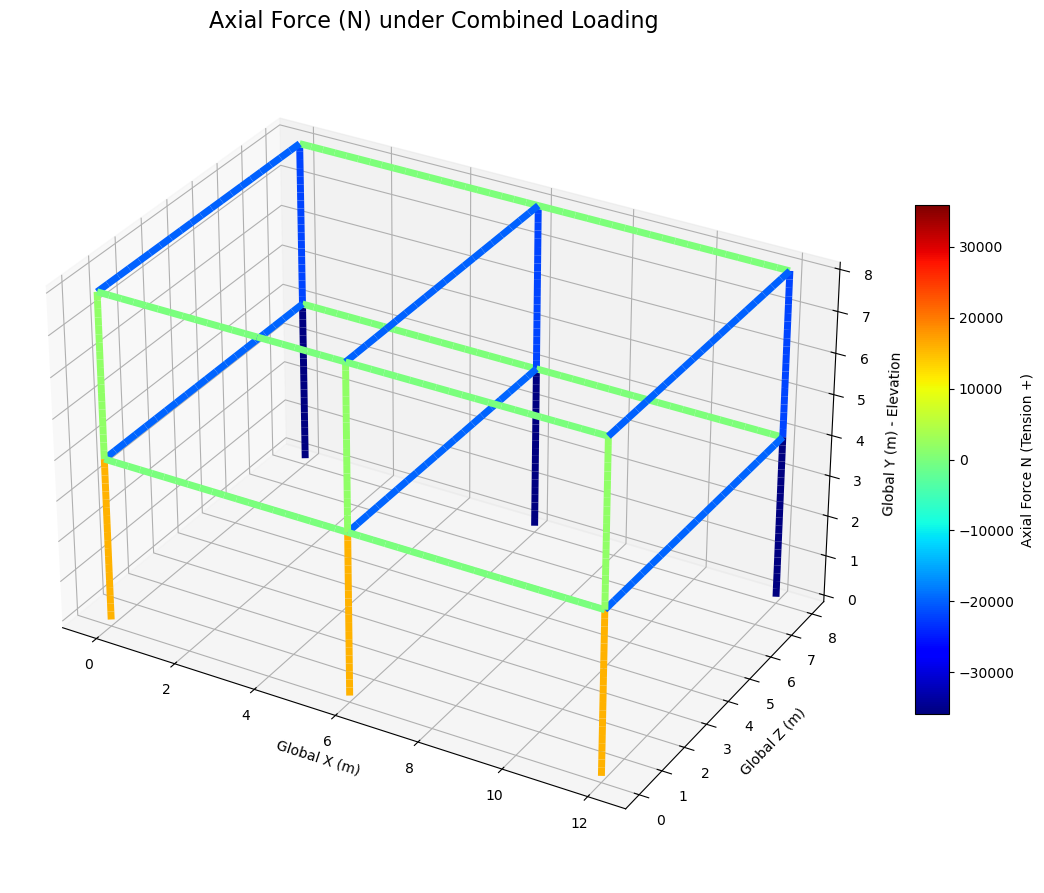

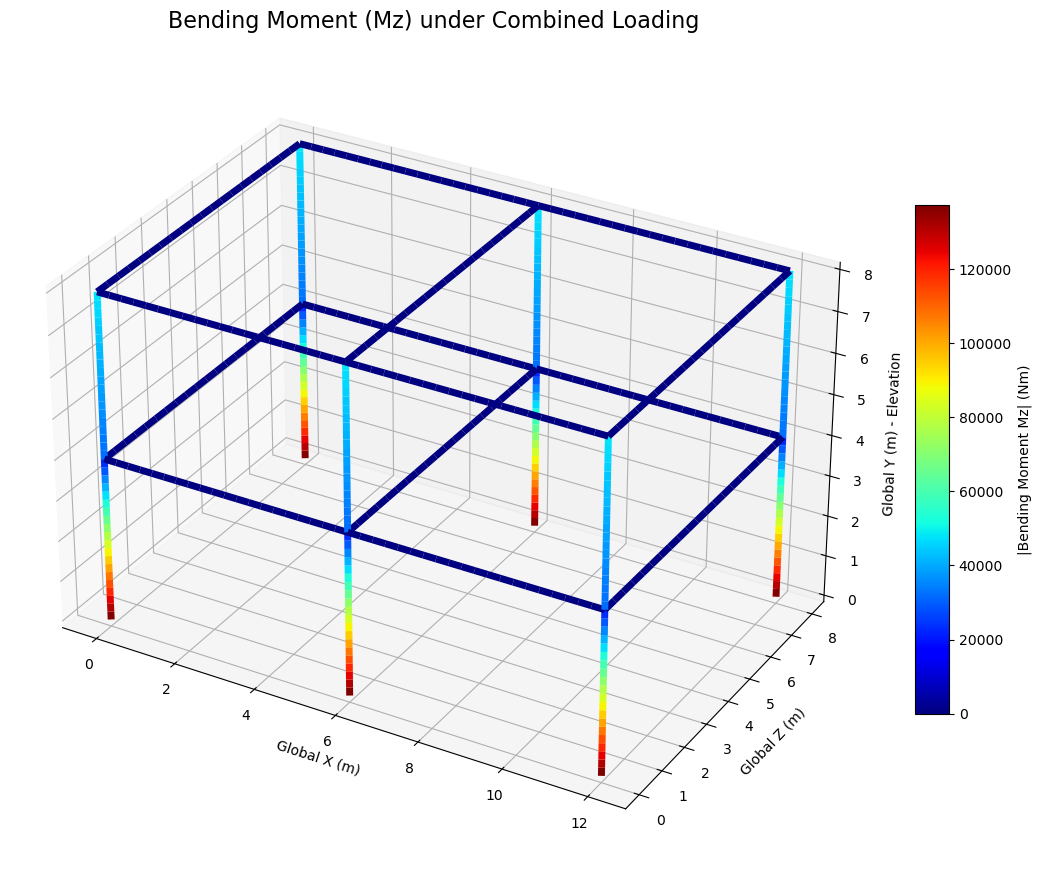

In [8]:
# main_lateral_load_test.py

import numpy as np
from itertools import combinations

# Import the refactored classes
from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer
from visualizer import Visualizer

"""
Analyzes a manually-defined two-story building subjected to both
gravity and lateral (horizontal) loads, with corrected symmetric definitions.
"""
print("--- Setting up a 2-Story Frame with Lateral Loads ---")

# 1. --- Define Structure Geometry and Properties ---
E_steel = 200e9
nu_steel = 0.3
rho_steel = 7850  # Density of steel in kg/m^3
props = {'A': 0.0123, 'Iz': 222e-6, 'Iy': 72.4e-6, 'J': 800e-9, 'cy': 0.155, 'cz': 0.1525, 'nu': nu_steel, 'rho': rho_steel}

nodes = [
    # Ground Floor (Y=0)
    Node(0,  0, 0), Node(6,  0, 0), Node(12, 0, 0), # Nodes 0, 1, 2
    Node(0,  0, 8), Node(6,  0, 8), Node(12, 0, 8), # Nodes 3, 4, 5
    # First Floor (Y=4)
    Node(0,  4, 0), Node(6,  4, 0), Node(12, 4, 0), # Nodes 6, 7, 8
    Node(0,  4, 8), Node(6,  4, 8), Node(12, 4, 8), # Nodes 9, 10, 11
    # Roof Level (Y=8)
    Node(0,  8, 0), Node(6,  8, 0), Node(12, 8, 0), # Nodes 12, 13, 14
    Node(0,  8, 8), Node(6,  8, 8), Node(12, 8, 8), # Nodes 15, 16, 17
]

# --- THIS IS THE FIX: A consistent ref_vector is now used for all horizontal beams ---
horizontal_beam_ref_vector = np.array([0, 1, 0]) # Global Y-up

beams = [
    # Columns Story 1
    Beam(0, 6, E_steel, **props, ref_vector=np.array([1,0,0])),
    Beam(1, 7, E_steel, **props, ref_vector=np.array([1,0,0])),
    Beam(2, 8, E_steel, **props, ref_vector=np.array([1,0,0])),
    Beam(3, 9, E_steel, **props, ref_vector=np.array([1,0,0])),
    Beam(4, 10, E_steel, **props, ref_vector=np.array([1,0,0])),
    Beam(5, 11, E_steel, **props, ref_vector=np.array([1,0,0])),
    # Columns Story 2
    Beam(6, 12, E_steel, **props, ref_vector=np.array([1,0,0])),
    Beam(7, 13, E_steel, **props, ref_vector=np.array([1,0,0])),
    Beam(8, 14, E_steel, **props, ref_vector=np.array([1,0,0])),
    Beam(9, 15, E_steel, **props, ref_vector=np.array([1,0,0])),
    Beam(10,16, E_steel, **props, ref_vector=np.array([1,0,0])),
    Beam(11,17, E_steel, **props, ref_vector=np.array([1,0,0])),
    # Beams First Floor (Y=4)
    Beam(6, 7, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
    Beam(7, 8, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
    Beam(9, 10, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
    Beam(10,11, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
    Beam(6, 9, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
    Beam(7, 10, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
    Beam(8, 11, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
    # Beams Roof (Y=8)
    Beam(12,13, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
    Beam(13,14, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
    Beam(15,16, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
    Beam(16,17, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
    Beam(12,15, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
    Beam(13,16, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
    Beam(14,17, E_steel, **props, ref_vector=horizontal_beam_ref_vector),
]

beams_at_node = [
    [0], [1], [2], [3], [4], [5], [0, 6, 12, 16], [1, 7, 12, 13, 17],
    [2, 8, 13, 18], [3, 9, 14, 16], [4, 10, 14, 15, 17], [5, 11, 15, 18],
    [6, 19, 23], [7, 19, 20, 24], [8, 20, 25], [9, 21, 23],
    [10, 21, 22, 24], [11, 22, 25],
]
connections = []
for node_beams_list in beams_at_node:
    if len(node_beams_list) > 1:
        for b1, b2 in combinations(node_beams_list, 2):
            connections.append(Connection(b1, b2, 'rigid'))

# --- Define Combined Load Case ---

loads = [
    {'node_idx': 12, 'Fy': -10000}, {'node_idx': 13, 'Fy': -10000},
    {'node_idx': 14, 'Fy': -10000}, {'node_idx': 15, 'Fy': -10000},
    {'node_idx': 16, 'Fy': -10000}, {'node_idx': 17, 'Fy': -10000},
]

lateral_force = 4e4
lateral_load_nodes = [6, 7, 8, 12, 13, 14]
for node_idx in lateral_load_nodes:
    loads.append({'node_idx': node_idx, 'Fz': lateral_force})

# --- Define Boundary Conditions ---
boundary_conditions = []
for i in range(6): # Fix base nodes 0 through 5
    boundary_conditions.append({'node_idx': i, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0})

# --- Run the Analysis ---
print("\n--- Starting Analysis ---")
analyzer = FrameAnalyzer(nodes, beams, connections)

if analyzer.solve(loads, boundary_conditions):
    print("Analysis successful.")

    # --- Display & Visualize Results ---
    print("\n--- Key Results ---")
    results = analyzer.get_results()

    print("\n--- Ground Floor Column Axial Forces ---")
    # Compare column 0 (x=0) vs column 2 (x=12) - they should now be symmetric
    axial_force_b0 = results[0]['node1']['N']
    axial_force_b2 = results[2]['node1']['N']
    print(f"Beam 0 (X=0) Axial Force: {axial_force_b0:.2f} N")
    print(f"Beam 2 (X=12) Axial Force: {axial_force_b2:.2f} N")

    visualizer = Visualizer(analyzer)
    print("\nGenerating visualizations...")

    visualizer.plot(result_type='axial_force', title="Axial Force (N) under Combined Loading")
    visualizer.plot(result_type='moment_z', title="Bending Moment (Mz) under Combined Loading")

else:
    print("Analysis failed.")

--- Setting up a 3-Story Frame with Combined Loads + Self-Weight ---
Defining nodes manually...
Defining beams and columns manually...
Defining rigid connections manually...
Model generated: 24 nodes, 39 beams, 112 rigid connections.

Adding self-weight for all beams...

--- Starting Analysis ---
Analysis successful.

Generating visualization...


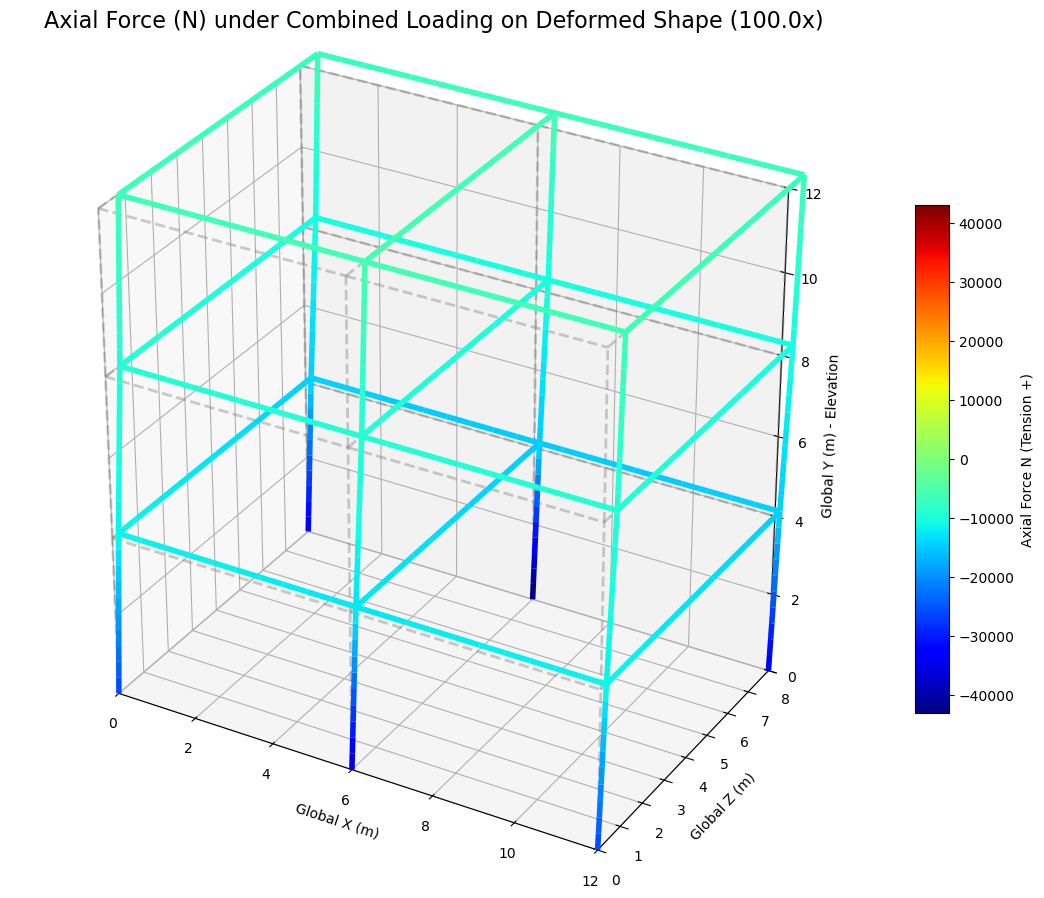

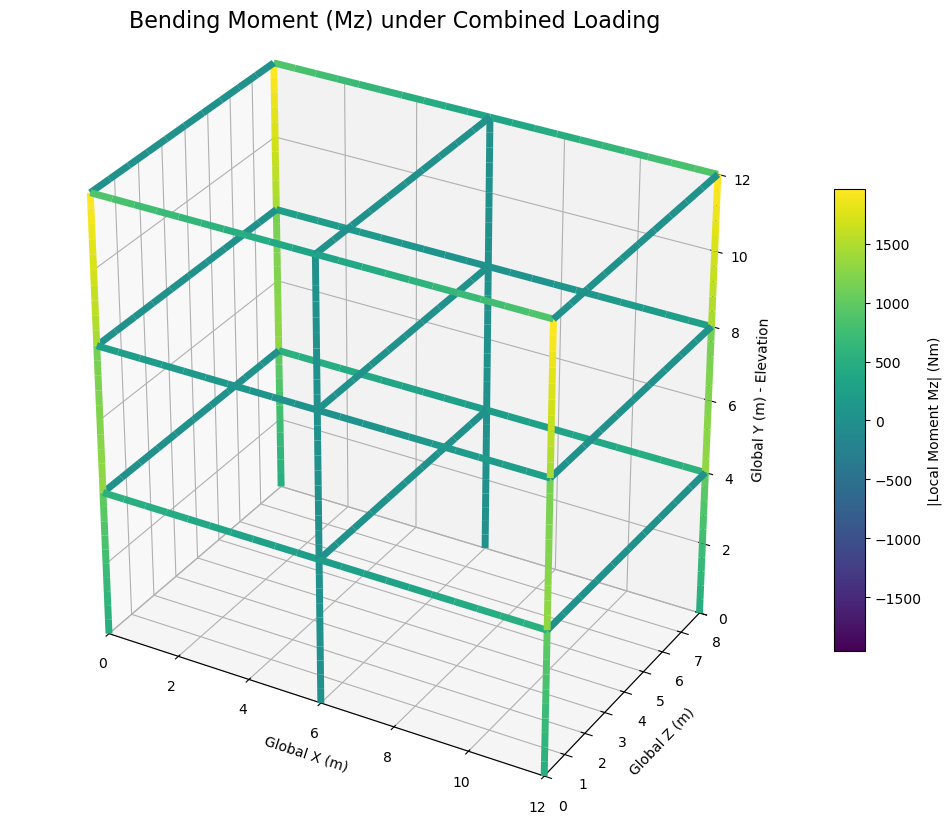

In [13]:
# main.py

import numpy as np
from itertools import combinations

# Import the refactored classes
from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer
from visualizer import Visualizer

def main():
    """
    Analyzes a manually-defined THREE-story building, including gravity loads,
    lateral loads, and the structure's own self-weight.
    """
    print("--- Setting up a 3-Story Frame with Combined Loads + Self-Weight ---")

    # 1. --- Define Material and Section Properties ---
    E_steel = 200e9
    nu_steel = 0.3
    rho_steel = 7850  # Density of steel in kg/m^3
    g = 9.81         # Acceleration due to gravity in m/s^2

    # Add rho to the properties dictionary
    props = {'A': 0.0123, 'Iz': 222e-6, 'Iy': 72.4e-6, 'J': 800e-9, 'cy': 0.155, 'cz': 0.1525, 'nu': nu_steel, 'rho': rho_steel}

    # 2. --- Manually Define the Structure ---
    print("Defining nodes manually...")
    nodes = [
        # Ground Floor (Y=0)
        Node(0,  0, 0), Node(6,  0, 0), Node(12, 0, 0), # Nodes 0, 1, 2
        Node(0,  0, 8), Node(6,  0, 8), Node(12, 0, 8), # Nodes 3, 4, 5
        # First Floor (Y=4)
        Node(0,  4, 0), Node(6,  4, 0), Node(12, 4, 0), # Nodes 6, 7, 8
        Node(0,  4, 8), Node(6,  4, 8), Node(12, 4, 8), # Nodes 9, 10, 11
        # Second Floor (Y=8)
        Node(0,  8, 0), Node(6,  8, 0), Node(12, 8, 0), # Nodes 12, 13, 14
        Node(0,  8, 8), Node(6,  8, 8), Node(12, 8, 8), # Nodes 15, 16, 17
        # Roof Level (Y=12)
        Node(0,  12, 0), Node(6,  12, 0), Node(12, 12, 0),# Nodes 18, 19, 20
        Node(0,  12, 8), Node(6,  12, 8), Node(12, 12, 8),# Nodes 21, 22, 23
    ]

    print("Defining beams and columns manually...")
    beams = [
        # Columns Story 1
        Beam(0, 6, E_steel, **props), Beam(1, 7, E_steel, **props), Beam(2, 8, E_steel, **props),
        Beam(3, 9, E_steel, **props), Beam(4, 10, E_steel, **props), Beam(5, 11, E_steel, **props),
        # Columns Story 2
        Beam(6, 12, E_steel, **props), Beam(7, 13, E_steel, **props), Beam(8, 14, E_steel, **props),
        Beam(9, 15, E_steel, **props), Beam(10,16, E_steel, **props), Beam(11,17, E_steel, **props),
        # Columns Story 3
        Beam(12, 18, E_steel, **props), Beam(13, 19, E_steel, **props), Beam(14, 20, E_steel, **props),
        Beam(15, 21, E_steel, **props), Beam(16, 22, E_steel, **props), Beam(17, 23, E_steel, **props),
        # Beams First Floor (Y=4)
        Beam(6, 7, E_steel, **props), Beam(7, 8, E_steel, **props),
        Beam(9, 10, E_steel, **props), Beam(10,11, E_steel, **props),
        Beam(6, 9, E_steel, **props), Beam(7, 10, E_steel, **props), Beam(8, 11, E_steel, **props),
        # Beams Second Floor (Y=8)
        Beam(12,13, E_steel, **props), Beam(13,14, E_steel, **props),
        Beam(15,16, E_steel, **props), Beam(16,17, E_steel, **props),
        Beam(12,15, E_steel, **props), Beam(13,16, E_steel, **props), Beam(14,17, E_steel, **props),
        # Beams Roof (Y=12)
        Beam(18,19, E_steel, **props), Beam(19,20, E_steel, **props),
        Beam(21,22, E_steel, **props), Beam(22,23, E_steel, **props),
        Beam(18,21, E_steel, **props), Beam(19,22, E_steel, **props), Beam(20,23, E_steel, **props),
    ]

    print("Defining rigid connections manually...")
    # Corrected connectivity list for the 3-story building
    beams_at_node = [
        [0], [1], [2], [3], [4], [5],                # Ground nodes
        [0, 6, 18, 22], [1, 7, 18, 19, 23], [2, 8, 19, 24],
        [3, 9, 20, 22], [4, 10, 20, 21, 23], [5, 11, 21, 24],
        [6, 12, 25, 29], [7, 13, 25, 26, 30], [8, 14, 26, 31],
        [9, 15, 27, 29], [10, 16, 27, 28, 30], [11, 17, 28, 31],
        [12, 32, 36], [13, 32, 33, 37], [14, 33, 38],
        [15, 34, 36], [16, 34, 35, 37], [17, 35, 38]
    ]
    connections = []
    for node_beams_list in beams_at_node:
        if len(node_beams_list) > 1:
            for b1, b2 in combinations(node_beams_list, 2):
                connections.append(Connection(b1, b2, 'rigid'))

    print(f"Model generated: {len(nodes)} nodes, {len(beams)} beams, {len(connections)} rigid connections.")

    # 3. --- Define Loads and Boundary Conditions ---
    loads = []

    # Add point loads to roof
    roof_nodes = [18, 19, 20, 21, 22, 23]
    for node_idx in roof_nodes:
        loads.append({'node_idx': node_idx, 'Fy': -1e4})

    # Add lateral loads to the front face
    lateral_force = 2000
    lateral_load_nodes = [6, 7, 8, 12, 13, 14, 18, 19, 20]
    for node_idx in lateral_load_nodes:
        loads.append({'node_idx': node_idx, 'Fz': lateral_force})

    # --- THIS IS THE NEW SECTION ---
    # Add self-weight for every beam in the structure
    print("\nAdding self-weight for all beams...")
    temp_analyzer = FrameAnalyzer(nodes, beams, connections)
    global_gravity_vector = np.array([0, -1, 0]) # Global -Y direction

    for i, beam in enumerate(beams):
        temp_analyzer._compute_beam_properties(beam)
        # Calculate distributed load magnitude (force per unit length)
        q_magnitude = -beam.rho * g * beam.A
        # Transform the global gravity vector into the beam's local coordinates
        q_local_direction = beam.rotation_matrix @ global_gravity_vector
        # Assign the load magnitude to the local y and z components
        qy_load = q_magnitude * q_local_direction[1]
        qz_load = q_magnitude * q_local_direction[2]
        loads.append({'beam_idx': i, 'qy': qy_load, 'qz': qz_load})

    boundary_conditions = []
    for i in range(6): # Fix base nodes 0 through 5
        boundary_conditions.append({'node_idx': i, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0})

    # 4. --- Run the Analysis ---
    print("\n--- Starting Analysis ---")
    analyzer = FrameAnalyzer(nodes, beams, connections)

    if analyzer.solve(loads, boundary_conditions):
        print("Analysis successful.")

        # 5. --- Display & Visualize Results ---
        visualizer = Visualizer(analyzer)
        print("\nGenerating visualization...")
        visualizer.plot_deformed_shape(result_type='axial_force', title="Axial Force (N) under Combined Loading", amplification_factor=1e2)
        visualizer.plot(result_type='moment_z', title="Bending Moment (Mz) under Combined Loading")

    else:
        print("Analysis failed.")

if __name__ == "__main__":
    main()

--- Setting up a 3-Story Frame with Corrected Single Diagonal Bracing ---
Defining nodes...
Defining beams, columns, and corrected diagonal braces...
Defining rigid connections...
Model generated: 24 nodes, 42 beams, 137 rigid connections.

--- Starting Analysis ---
Analysis successful.

Generating visualizations...


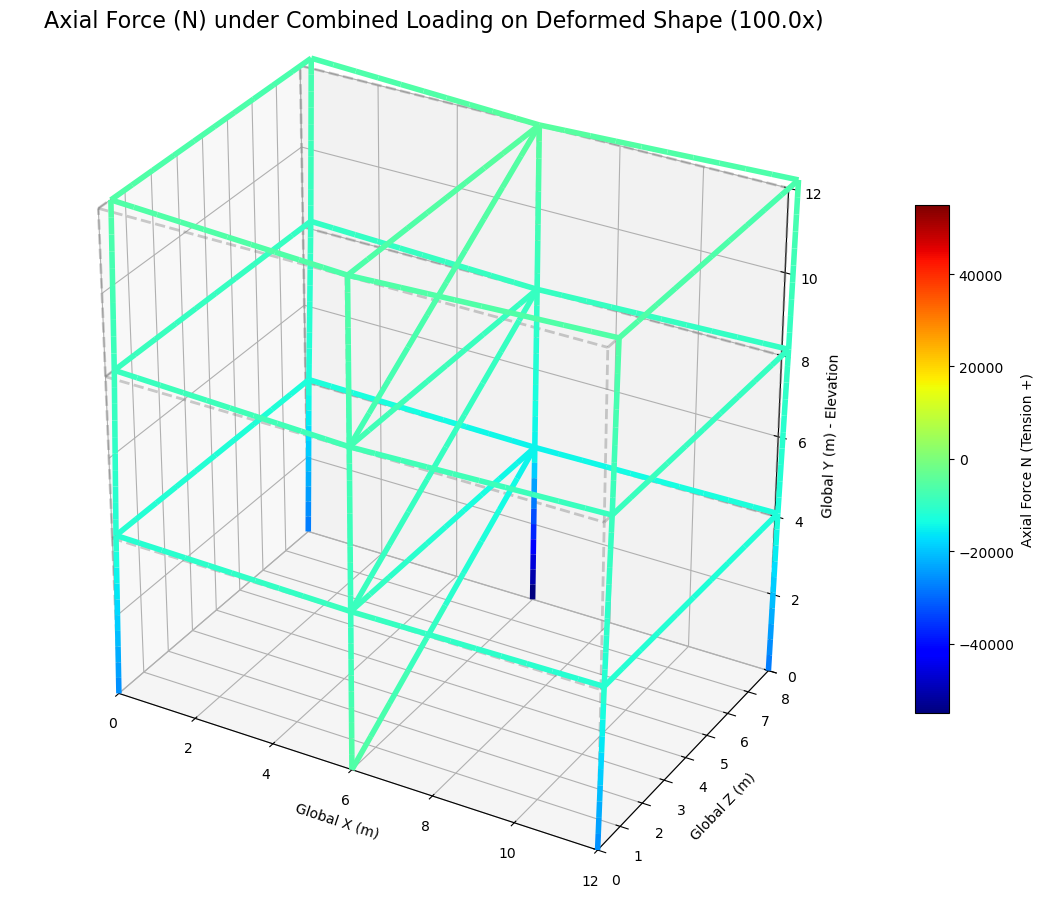

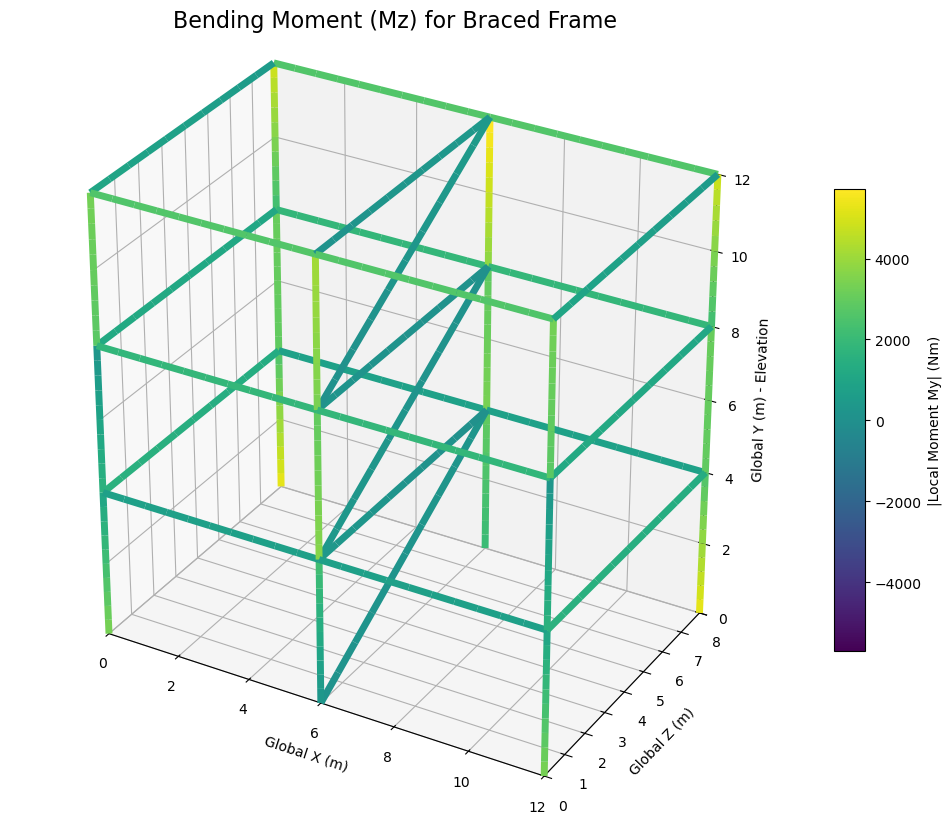

In [15]:
# main_braced_frame.py

import numpy as np
from itertools import combinations

# Import the refactored classes
from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer
from visualizer import Visualizer

def main():
    """
    Analyzes a manually-defined THREE-story building with a single diagonal brace
    on each story of the central frame.
    """
    print("--- Setting up a 3-Story Frame with Corrected Single Diagonal Bracing ---")

    # 1. --- Define Material and Section Properties ---
    E_steel = 200e9
    nu_steel = 0.3
    rho_steel = 7850
    g = -9.81

    col_props = {'A': 0.0123, 'Iz': 222e-6, 'Iy': 72.4e-6, 'J': 800e-9, 'cy': 0.155, 'cz': 0.1525, 'nu': nu_steel, 'rho': rho_steel}
    beam_props = {'A': 0.0104, 'Iz': 370e-6, 'Iy': 19.9e-6, 'J': 650e-9, 'cy': 0.2285, 'cz': 0.095, 'nu': nu_steel, 'rho': rho_steel}
    brace_props = {'A': 0.005, 'Iz': 50e-6, 'Iy': 20e-6, 'J': 100e-9, 'cy': 0.1, 'cz': 0.1, 'nu': nu_steel, 'rho': rho_steel}


    # 2. --- Manually Define the Structure ---
    print("Defining nodes...")
    nodes = [
        # Ground Floor (Y=0)
        Node(0,  0, 0), Node(6,  0, 0), Node(12, 0, 0), # Nodes 0-2
        Node(0,  0, 8), Node(6,  0, 8), Node(12, 0, 8), # Nodes 3-5
        # First Floor (Y=4)
        Node(0,  4, 0), Node(6,  4, 0), Node(12, 4, 0), # Nodes 6-8
        Node(0,  4, 8), Node(6,  4, 8), Node(12, 4, 8), # Nodes 9-11
        # Second Floor (Y=8)
        Node(0,  8, 0), Node(6,  8, 0), Node(12, 8, 0), # Nodes 12-14
        Node(0,  8, 8), Node(6,  8, 8), Node(12, 8, 8), # Nodes 15-17
        # Roof Level (Y=12)
        Node(0,  12, 0), Node(6,  12, 0), Node(12, 12, 0),# Nodes 18-20
        Node(0,  12, 8), Node(6,  12, 8), Node(12, 12, 8),# Nodes 21-23
    ]

    print("Defining beams, columns, and corrected diagonal braces...")
    beams = [
        # Columns (Beams 0-17)
        Beam(0, 6, E_steel, **col_props), Beam(1, 7, E_steel, **col_props), Beam(2, 8, E_steel, **col_props),
        Beam(3, 9, E_steel, **col_props), Beam(4, 10, E_steel, **col_props), Beam(5, 11, E_steel, **col_props),
        Beam(6, 12, E_steel, **col_props), Beam(7, 13, E_steel, **col_props), Beam(8, 14, E_steel, **col_props),
        Beam(9, 15, E_steel, **col_props), Beam(10,16, E_steel, **col_props), Beam(11,17, E_steel, **col_props),
        Beam(12, 18, E_steel, **col_props), Beam(13, 19, E_steel, **col_props), Beam(14, 20, E_steel, **col_props),
        Beam(15, 21, E_steel, **col_props), Beam(16, 22, E_steel, **col_props), Beam(17, 23, E_steel, **col_props),
        # Beams First Floor (Y=4) (Beams 18-24)
        Beam(6, 7, E_steel, **beam_props), Beam(7, 8, E_steel, **beam_props),
        Beam(9, 10, E_steel, **beam_props), Beam(10,11, E_steel, **beam_props),
        Beam(6, 9, E_steel, **beam_props), Beam(7, 10, E_steel, **beam_props), Beam(8, 11, E_steel, **beam_props),
        # Beams Second Floor (Y=8) (Beams 25-31)
        Beam(12,13, E_steel, **beam_props), Beam(13,14, E_steel, **beam_props),
        Beam(15,16, E_steel, **beam_props), Beam(16,17, E_steel, **beam_props),
        Beam(12,15, E_steel, **beam_props), Beam(13,16, E_steel, **beam_props), Beam(14,17, E_steel, **beam_props),
        # Beams Roof (Y=12) (Beams 32-38)
        Beam(18,19, E_steel, **beam_props), Beam(19,20, E_steel, **beam_props),
        Beam(21,22, E_steel, **beam_props), Beam(22,23, E_steel, **beam_props),
        Beam(18,21, E_steel, **beam_props), Beam(19,22, E_steel, **beam_props), Beam(20,23, E_steel, **beam_props),

        # --- BRACES on face X=6 ---
        Beam(1, 10, E_steel, **brace_props), # Beam 39: Story 1 Brace from (6,0,0) to (6,4,8)
        Beam(7, 16, E_steel, **brace_props), # Beam 40: Story 2 Brace from (6,4,0) to (6,8,8)
        Beam(13, 22, E_steel, **brace_props),# Beam 41: Story 3 Brace from (6,8,0) to (6,12,8)
    ]

    print("Defining rigid connections...")
    # --- UPDATED CONNECTIVITY LIST to include correct braces ---
    beams_at_node = [
        [0], [1, 39], [2], [3], [4], [5], # Ground nodes
        [0, 6, 18, 22],                  # Node 6
        [1, 7, 18, 19, 23, 40],          # Node 7
        [2, 8, 19, 24],                  # Node 8
        [3, 9, 20, 22],                  # Node 9
        [4, 10, 20, 21, 23, 39],         # Node 10
        [5, 11, 21, 24],                 # Node 11
        [6, 12, 25, 29],                 # Node 12
        [7, 13, 25, 26, 30, 41],         # Node 13
        [8, 14, 26, 31],                 # Node 14
        [9, 15, 27, 29],                 # Node 15
        [10, 16, 27, 28, 30, 40],        # Node 16
        [11, 17, 28, 31],                # Node 17
        [12, 32, 36],                    # Node 18
        [13, 32, 33, 37],                # Node 19
        [14, 33, 38],                    # Node 20
        [15, 34, 36],                    # Node 21
        [16, 34, 35, 37, 41],            # Node 22
        [17, 35, 38],                    # Node 23
    ]
    connections = []
    for node_beams_list in beams_at_node:
        if len(node_beams_list) > 1:
            for b1, b2 in combinations(node_beams_list, 2):
                connections.append(Connection(b1, b2, 'rigid'))

    print(f"Model generated: {len(nodes)} nodes, {len(beams)} beams, {len(connections)} rigid connections.")

    # --- Load and Boundary Conditions (Unchanged) ---
    loads = [{'node_idx': n, 'Fy': -1e4} for n in [18,19,20,21,22,23]]
    for n in [6,7,8,12,13,14,18,19,20]: loads.append({'node_idx':n, 'Fz': 2e3})
    temp_analyzer = FrameAnalyzer(nodes, beams, connections)
    global_gravity_vector = np.array([0, -1, 0])
    for i, beam in enumerate(beams):
        temp_analyzer._compute_beam_properties(beam)
        q_magnitude = beam.rho * g * beam.A
        q_local_direction = beam.rotation_matrix @ global_gravity_vector
        loads.append({'beam_idx': i, 'qy': q_magnitude*q_local_direction[1], 'qz': q_magnitude*q_local_direction[2]})
    boundary_conditions = [{'node_idx': i, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0} for i in range(6)]

    # --- Run Analysis and Visualize ---
    print("\n--- Starting Analysis ---")
    analyzer = FrameAnalyzer(nodes, beams, connections)
    if analyzer.solve(loads, boundary_conditions):
        print("Analysis successful.")
        visualizer = Visualizer(analyzer)
        print("\nGenerating visualizations...")
        visualizer.plot_deformed_shape(result_type='axial_force', title="Axial Force (N) under Combined Loading", amplification_factor=1e2)
        visualizer.plot(result_type='moment_y', title="Bending Moment (Mz) for Braced Frame")
    else:
        print("Analysis failed.")

if __name__ == "__main__":
    main()

--- Setting up a 3-Story Frame with Corrected Single Diagonal Bracing ---
Defining nodes...
Defining nodes manually...
Defining beams, columns, and new REVERSED diagonal braces...
Defining rigid connections, including corrected braces...
Model generated: 24 nodes, 42 beams, 143 rigid connections.

--- Starting Analysis ---
Analysis successful.

Generating visualizations...


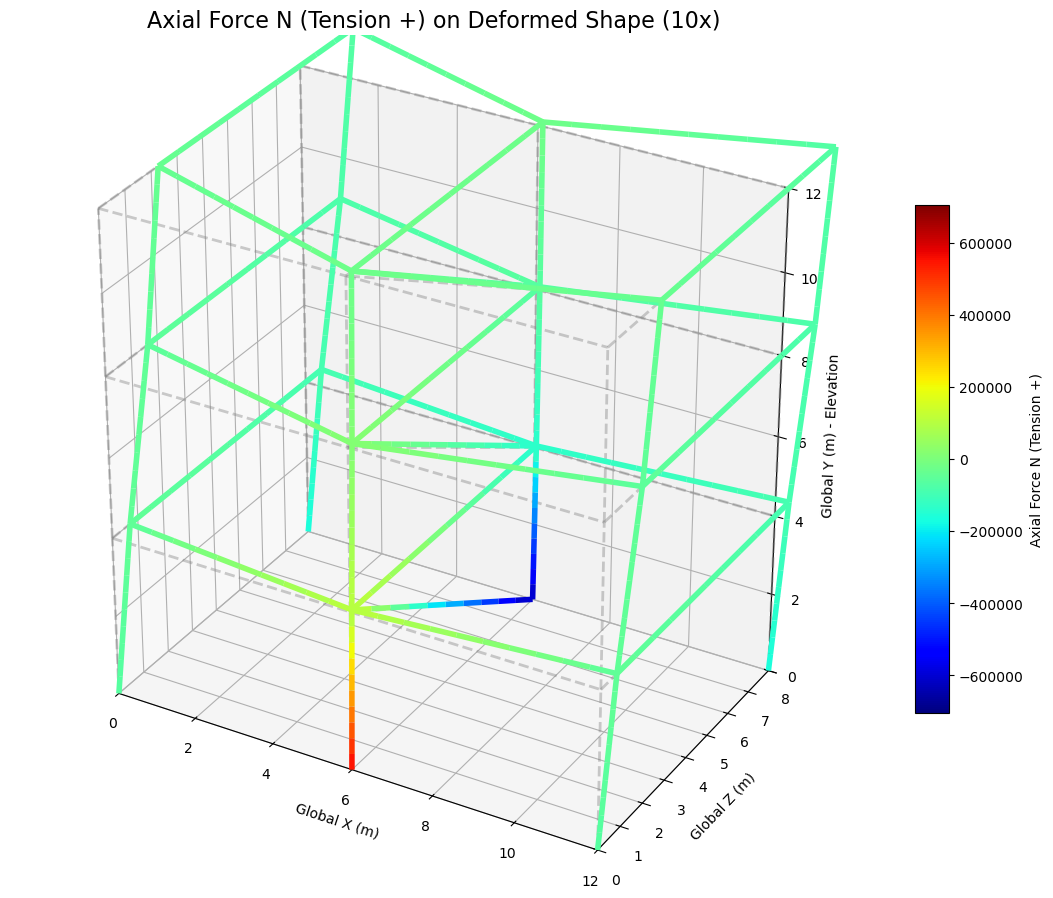

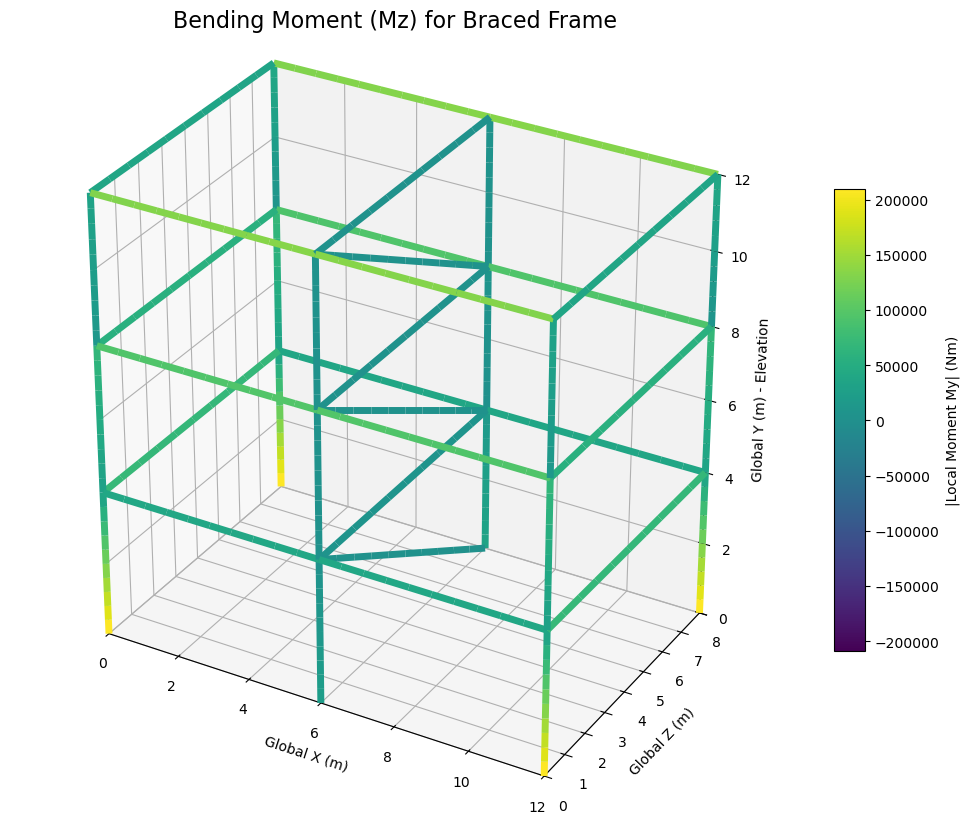

In [5]:
# main_braced_frame.py

import numpy as np
from itertools import combinations

# Import the refactored classes
from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer
from visualizer import Visualizer

def main():
    """
    Analyzes a manually-defined THREE-story building with a single diagonal brace
    on each story of the central frame.
    """
    print("--- Setting up a 3-Story Frame with Corrected Single Diagonal Bracing ---")

    # 1. --- Define Material and Section Properties ---
    E_steel = 200e9
    nu_steel = 0.3
    rho_steel = 7850
    g = -9.81

    col_props = {'A': 0.0123, 'Iz': 222e-6, 'Iy': 72.4e-6, 'J': 800e-9, 'cy': 0.155, 'cz': 0.1525, 'nu': nu_steel, 'rho': rho_steel}
    beam_props = {'A': 0.0104, 'Iz': 370e-6, 'Iy': 19.9e-6, 'J': 650e-9, 'cy': 0.2285, 'cz': 0.095, 'nu': nu_steel, 'rho': rho_steel}
    brace_props = {'A': 0.005, 'Iz': 50e-6, 'Iy': 20e-6, 'J': 100e-9, 'cy': 0.1, 'cz': 0.1, 'nu': nu_steel, 'rho': rho_steel}


    # 2. --- Manually Define the Structure ---
    print("Defining nodes...")
    nodes = [
        # Ground Floor (Y=0)
        Node(0,  0, 0), Node(6,  0, 0), Node(12, 0, 0), # Nodes 0-2
        Node(0,  0, 8), Node(6,  0, 8), Node(12, 0, 8), # Nodes 3-5
        # First Floor (Y=4)
        Node(0,  4, 0), Node(6,  4, 0), Node(12, 4, 0), # Nodes 6-8
        Node(0,  4, 8), Node(6,  4, 8), Node(12, 4, 8), # Nodes 9-11
        # Second Floor (Y=8)
        Node(0,  8, 0), Node(6,  8, 0), Node(12, 8, 0), # Nodes 12-14
        Node(0,  8, 8), Node(6,  8, 8), Node(12, 8, 8), # Nodes 15-17
        # Roof Level (Y=12)
        Node(0,  12, 0), Node(6,  12, 0), Node(12, 12, 0),# Nodes 18-20
        Node(0,  12, 8), Node(6,  12, 8), Node(12, 12, 8),# Nodes 21-23
    ]

    # 2. --- Manually Define the Structure ---
    print("Defining nodes manually...")
    nodes = [
        # Ground Floor (Y=0)
        Node(0,  0, 0), Node(6,  0, 0), Node(12, 0, 0), # Nodes 0-2
        Node(0,  0, 8), Node(6,  0, 8), Node(12, 0, 8), # Nodes 3-5
        # First Floor (Y=4)
        Node(0,  4, 0), Node(6,  4, 0), Node(12, 4, 0), # Nodes 6-8
        Node(0,  4, 8), Node(6,  4, 8), Node(12, 4, 8), # Nodes 9-11
        # Second Floor (Y=8)
        Node(0,  8, 0), Node(6,  8, 0), Node(12, 8, 0), # Nodes 12-14
        Node(0,  8, 8), Node(6,  8, 8), Node(12, 8, 8), # Nodes 15-17
        # Roof Level (Y=12)
        Node(0,  12, 0), Node(6,  12, 0), Node(12, 12, 0),# Nodes 18-20
        Node(0,  12, 8), Node(6,  12, 8), Node(12, 12, 8),# Nodes 21-23
    ]

    print("Defining beams, columns, and new REVERSED diagonal braces...")
    beams = [
        # Columns (Beams 0-17)
        Beam(0, 6, E_steel, **col_props), Beam(1, 7, E_steel, **col_props), Beam(2, 8, E_steel, **col_props),
        Beam(3, 9, E_steel, **col_props), Beam(4, 10, E_steel, **col_props), Beam(5, 11, E_steel, **col_props),
        Beam(6, 12, E_steel, **col_props), Beam(7, 13, E_steel, **col_props), Beam(8, 14, E_steel, **col_props),
        Beam(9, 15, E_steel, **col_props), Beam(10,16, E_steel, **col_props), Beam(11,17, E_steel, **col_props),
        Beam(12, 18, E_steel, **col_props), Beam(13, 19, E_steel, **col_props), Beam(14, 20, E_steel, **col_props),
        Beam(15, 21, E_steel, **col_props), Beam(16, 22, E_steel, **col_props), Beam(17, 23, E_steel, **col_props),
        # Beams First Floor (Y=4) (Beams 18-24)
        Beam(6, 7, E_steel, **beam_props), Beam(7, 8, E_steel, **beam_props),
        Beam(9, 10, E_steel, **beam_props), Beam(10,11, E_steel, **beam_props),
        Beam(6, 9, E_steel, **beam_props), Beam(7, 10, E_steel, **beam_props), Beam(8, 11, E_steel, **beam_props),
        # Beams Second Floor (Y=8) (Beams 25-31)
        Beam(12,13, E_steel, **beam_props), Beam(13,14, E_steel, **beam_props),
        Beam(15,16, E_steel, **beam_props), Beam(16,17, E_steel, **beam_props),
        Beam(12,15, E_steel, **beam_props), Beam(13,16, E_steel, **beam_props), Beam(14,17, E_steel, **beam_props),
        # Beams Roof (Y=12) (Beams 32-38)
        Beam(18,19, E_steel, **beam_props), Beam(19,20, E_steel, **beam_props),
        Beam(21,22, E_steel, **beam_props), Beam(22,23, E_steel, **beam_props),
        Beam(18,21, E_steel, **beam_props), Beam(19,22, E_steel, **beam_props), Beam(20,23, E_steel, **beam_props),

        # --- CORRECTED REVERSED DIAGONAL BRACES on face X=6 ---
        # Connects back-bottom (Z=8) to front-top (Z=0) for each story on the X=6 plane
        Beam(4, 7, E_steel, **brace_props),   # Beam 39: Story 1 Brace from (6,0,8) to (6,4,0)
        Beam(10, 13, E_steel, **brace_props), # Beam 40: Story 2 Brace from (6,4,8) to (6,8,0)
        Beam(16, 19, E_steel, **brace_props), # Beam 41: Story 3 Brace from (6,8,8) to (6,12,0)
    ]

    print("Defining rigid connections, including corrected braces...")
    # --- UPDATED CONNECTIVITY LIST for corrected reversed braces ---
    beams_at_node = [
        [0], [1], [2], [3], [4, 39], [5],       # Ground nodes
        [0, 6, 18, 22],                         # Node 6
        [1, 7, 18, 19, 23, 39],                 # Node 7
        [2, 8, 19, 24],                         # Node 8
        [3, 9, 20, 22],                         # Node 9
        [4, 10, 20, 21, 23, 40],                # Node 10
        [5, 11, 21, 24],                        # Node 11
        [6, 12, 25, 29],                        # Node 12
        [7, 13, 25, 26, 30, 40, 41],            # Node 13
        [8, 14, 26, 31],                        # Node 14
        [9, 15, 27, 29],                        # Node 15
        [10, 16, 27, 28, 30, 41],               # Node 16
        [11, 17, 28, 31],                       # Node 17
        [12, 32, 36],                           # Node 18
        [13, 32, 33, 37, 41],                   # Node 19
        [14, 33, 38],                           # Node 20
        [15, 34, 36],                           # Node 21
        [16, 34, 35, 37],                       # Node 22
        [17, 35, 38],                           # Node 23
    ]
    connections = []
    for node_beams_list in beams_at_node:
        if len(node_beams_list) > 1:
            for b1, b2 in combinations(node_beams_list, 2):
                connections.append(Connection(b1, b2, 'rigid'))

    print(f"Model generated: {len(nodes)} nodes, {len(beams)} beams, {len(connections)} rigid connections.")

    # --- Load and Boundary Conditions ---
    loads = [{'node_idx': n, 'Fy': -1e5} for n in [18,19,20,21,22,23]]
    for n in [6,7,8,12,13,14,18,19,20]: loads.append({'node_idx':n, 'Fz': 1e5})
    temp_analyzer = FrameAnalyzer(nodes, beams, connections)
    global_gravity_vector = np.array([0, -1, 0])
    for i, beam in enumerate(beams):
        temp_analyzer._compute_beam_properties(beam)
        q_magnitude = beam.rho * g * beam.A
        q_local_direction = beam.rotation_matrix @ global_gravity_vector
        loads.append({'beam_idx': i, 'qy': q_magnitude*q_local_direction[1], 'qz': q_magnitude*q_local_direction[2]})
    boundary_conditions = [{'node_idx': i, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0} for i in range(6)]

    # --- Run Analysis and Visualize ---
    print("\n--- Starting Analysis ---")
    analyzer = FrameAnalyzer(nodes, beams, connections)
    if analyzer.solve(loads, boundary_conditions):
        print("Analysis successful.")
        visualizer = Visualizer(analyzer)
        print("\nGenerating visualizations...")
        visualizer.plot_deformed_shape(result_type='axial_force', amplification_factor=10)
        visualizer.plot(result_type='moment_y', title="Bending Moment (Mz) for Braced Frame")
    else:
        print("Analysis failed.")

if __name__ == "__main__":
    main()

--- Setting up a 3D Building Frame Analysis ---

--- Generating Visualizations ---


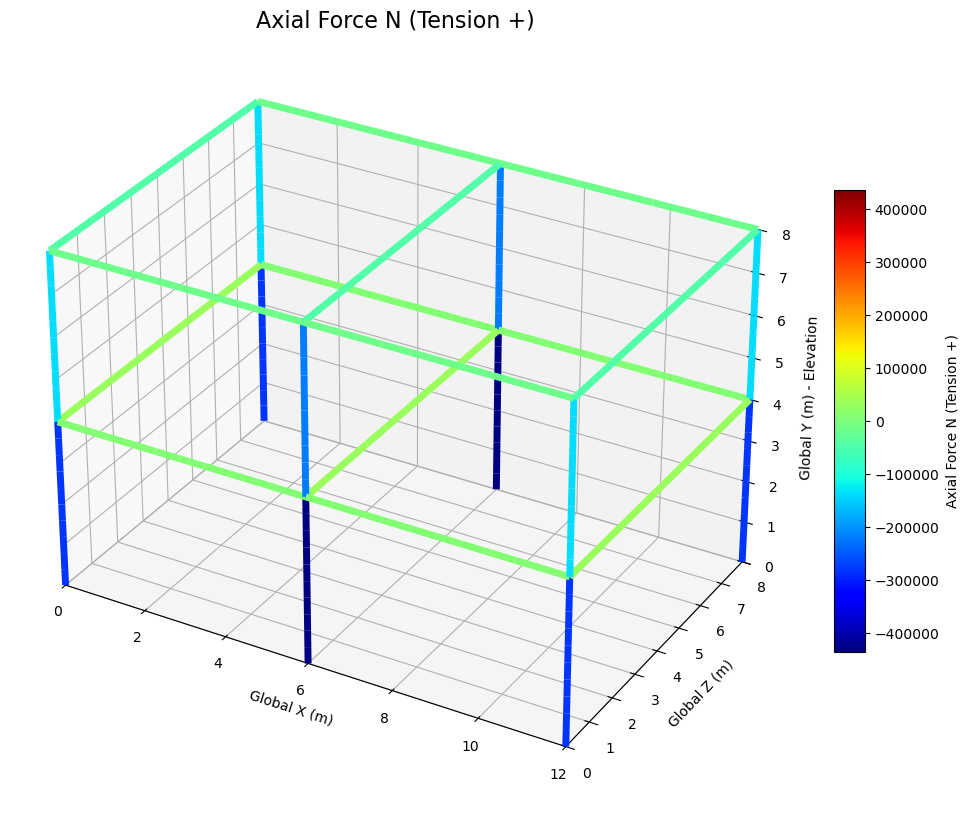

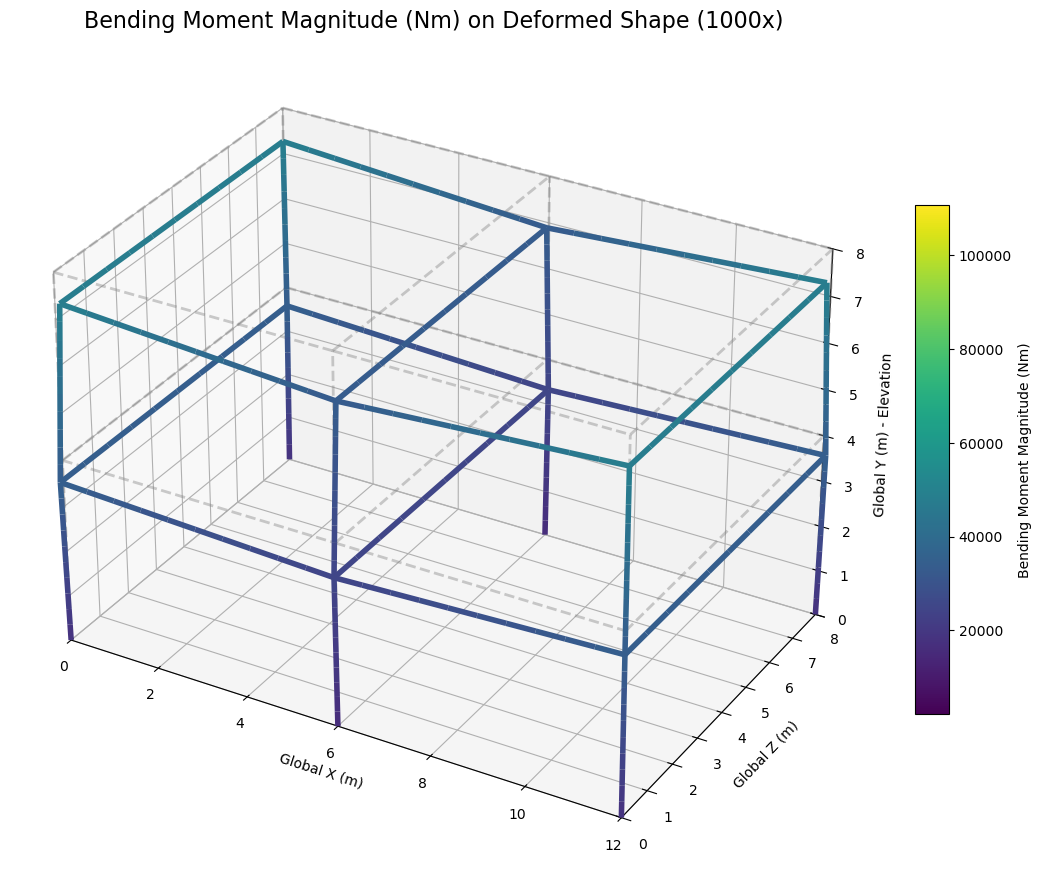

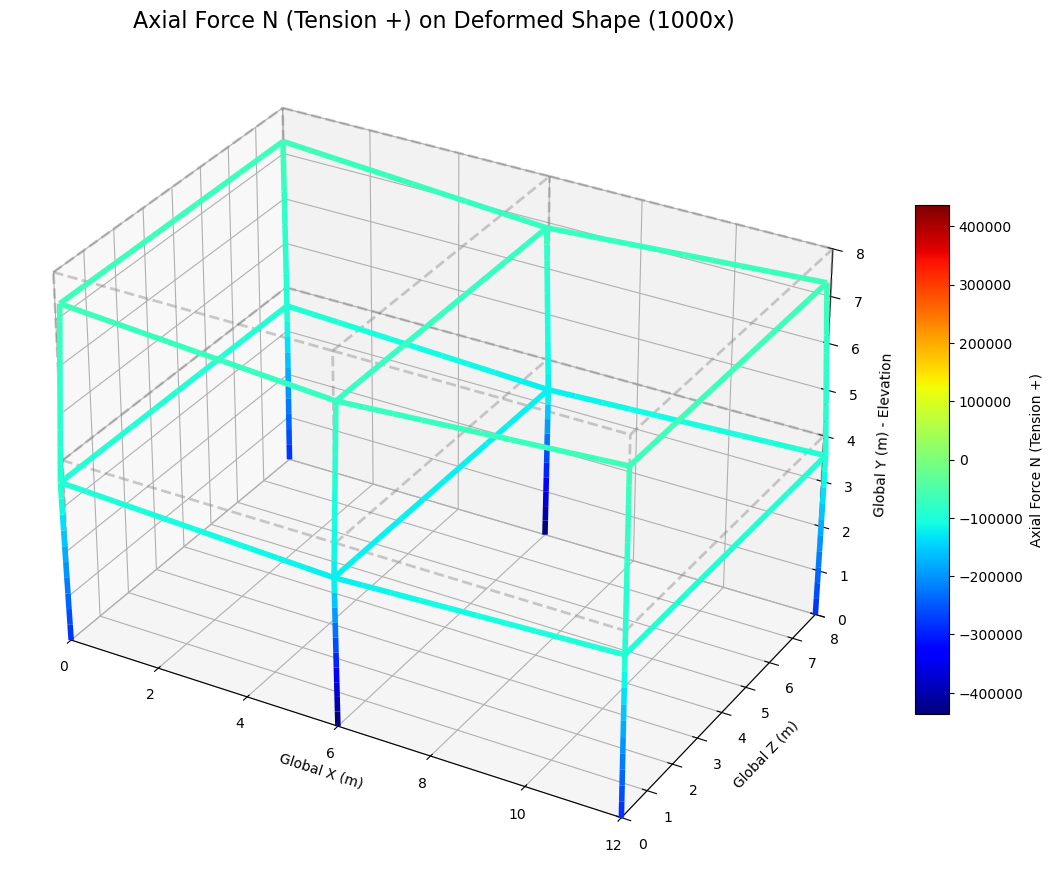

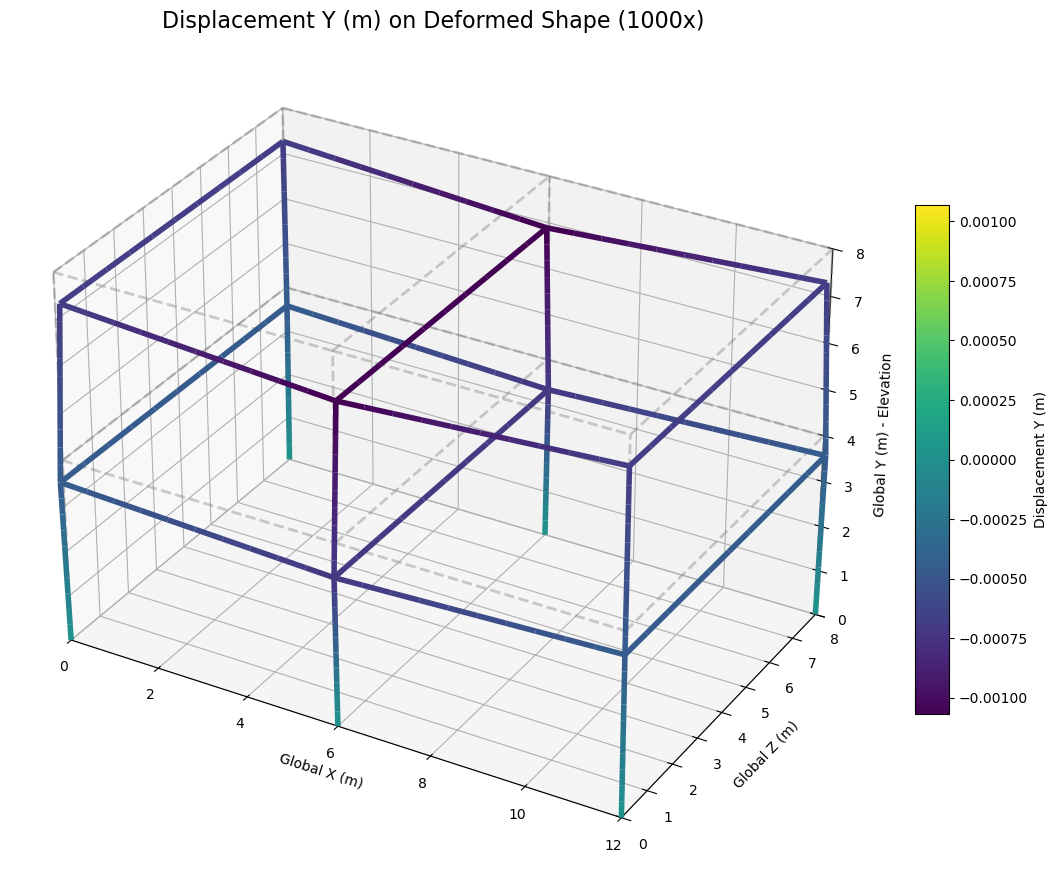

In [3]:
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import pickle
from itertools import combinations, product
from pathlib import Path
import time
import io

from structural_model import Node, Beam, Connection
import profile_manager
from frame_analyzer import FrameAnalyzer
from aisc360_verifier import AISC360Verifier
from visaulizer_web_app import Visualizer

# --- Page Configuration ---
st.set_page_config(
    page_title="Professional 3D Frame Analyzer",
    layout="wide",
    initial_sidebar_state="expanded",
)

# --- Session State Initialization ---
if 'model_defined' not in st.session_state:
    st.session_state.nodes = []
    st.session_state.beams = []
    st.session_state.connections = []
    st.session_state.loads = []  # List of load packs, each a dict with 'type' and 'data'
    st.session_state.boundary_conditions = []
    st.session_state.model_defined = False
    st.session_state.results = None
    st.session_state.optimization_results = None
    st.session_state.log = []
    st.session_state.selected_col_profile = None
    st.session_state.selected_beam_profile = None
    st.session_state.gravity_vector = [0.0, -1.0, 0.0]  # Default global gravity direction
    st.session_state.model_type = None  # Track Parametric or Custom model

# --- Data Loading ---
@st.cache_data
def load_profile_data(pickle_path):
    try:
        with open(pickle_path, "rb") as f:
            db = pickle.load(f)
            profile_manager.populate_database(db)
            profile_names = sorted(list(profile_manager.PROFILES_DATABASE.keys()))
            return db, profile_names
    except FileNotFoundError:
        return None, []

# --- Backend Logic ---
def build_parametric_model(n_stories, h_story, bays_x_str, bays_z_str, col_profile, beam_profile, E, nu, rho, use_custom_props=False, custom_props=None):
    try:
        bays_x = [float(x.strip()) for x in bays_x_str.split(',')]
        bays_z = [float(z.strip()) for z in bays_z_str.split(',')]
        n_stories, h_story = int(n_stories), float(h_story)
    except ValueError:
        st.error("Invalid parametric input. Please use numbers or comma-separated numbers.")
        return [], [], [], []

    # Validate profile names
    if not use_custom_props and (col_profile not in profile_manager.PROFILES_DATABASE or beam_profile not in profile_manager.PROFILES_DATABASE):
        st.error(f"Profile '{col_profile}' or '{beam_profile}' not found in profiles.pkl.")
        return [], [], [], []

    nx, nz = len(bays_x) + 1, len(bays_z) + 1
    x_pts, z_pts = [0.0] + list(np.cumsum(bays_x)), [0.0] + list(np.cumsum(bays_z))

    # Create nodes and assign node_idx
    nodes = [Node(x, s * h_story, z) for s in range(n_stories + 1) for z in z_pts for x in x_pts]
    for idx, node in enumerate(nodes):
        node.node_idx = idx

    if use_custom_props and custom_props:
        col_p = {'E': E, 'nu': nu, 'rho': rho, **custom_props['columns']}
        beam_p = {'E': E, 'nu': nu, 'rho': rho, **custom_props['beams']}
        col_profile_name = "Custom_Column"
        beam_profile_name = "Custom_Beam"
    else:
        col_p = profile_manager.get_beam_properties(col_profile, E, nu, rho)
        beam_p = profile_manager.get_beam_properties(beam_profile, E, nu, rho)
        col_profile_name = col_profile
        beam_profile_name = beam_profile

    beams, attach = [], [[] for _ in nodes]
    bid = 0

    def nid(s, ix, iz): return s * (nx * nz) + iz * nx + ix

    # Columns (vertical, ref_vector along global X)
    for s in range(n_stories):
        for iz in range(nz):
            for ix in range(nx):
                n1, n2 = nid(s, ix, iz), nid(s + 1, ix, iz)
                bm = Beam(n1, n2, **col_p, ref_vector=np.array([1, 0, 0]))
                bm.profile_name = col_profile_name
                # Compute length
                n1_pos = np.array([nodes[n1].x, nodes[n1].y, nodes[n1].z])
                n2_pos = np.array([nodes[n2].x, nodes[n2].y, nodes[n2].z])
                bm.length = np.linalg.norm(n2_pos - n1_pos)
                beams.append(bm)
                attach[n1].append(bid)
                attach[n2].append(bid)
                bid += 1

    # Beams (horizontal, ref_vector along global Y)
    for s in range(1, n_stories + 1):
        for iz in range(nz):  # X-direction
            for ix in range(nx - 1):
                n1, n2 = nid(s, ix, iz), nid(s, ix + 1, iz)
                bm = Beam(n1, n2, **beam_p, ref_vector=np.array([0, 1, 0]))
                bm.profile_name = beam_profile_name
                # Compute length
                n1_pos = np.array([nodes[n1].x, nodes[n1].y, nodes[n1].z])
                n2_pos = np.array([nodes[n2].x, nodes[n2].y, nodes[n2].z])
                bm.length = np.linalg.norm(n2_pos - n1_pos)
                beams.append(bm)
                attach[n1].append(bid)
                attach[n2].append(bid)
                bid += 1
        for ix in range(nx):  # Z-direction
            for iz in range(nz - 1):
                n1, n2 = nid(s, ix, iz), nid(s, ix, iz + 1)
                bm = Beam(n1, n2, **beam_p, ref_vector=np.array([0, 1, 0]))
                bm.profile_name = beam_profile_name
                # Compute length
                n1_pos = np.array([nodes[n1].x, nodes[n1].y, nodes[n1].z])
                n2_pos = np.array([nodes[n2].x, nodes[n2].y, nodes[n2].z])
                bm.length = np.linalg.norm(n2_pos - n1_pos)
                beams.append(bm)
                attach[n1].append(bid)
                attach[n2].append(bid)
                bid += 1

    conns = [Connection(b1, b2, 'rigid') for lst in attach if len(lst) > 1 for b1, b2 in combinations(lst, 2)]
    bcs = [{"node_idx": i, 'u': 0, 'v': 0, 'w': 0, 'theta_x': 0, 'theta_y': 0, 'theta_z': 0} for i in range(nx * nz)]

    return nodes, beams, conns, bcs

def parse_nodes_from_file(uploaded_file):
    try:
        df = pd.read_csv(uploaded_file, header=None, comment='#', skipinitialspace=True)
        nodes = [Node(row[1], row[2], row[3]) for _, row in df.iterrows()]
        for idx, node in enumerate(nodes):
            node.node_idx = idx
        return nodes
    except Exception as e:
        st.error(f"Error parsing node file: {e}")
        return []

# --- UI Rendering ---
def draw_sidebar():
    st.sidebar.title("🛠️ Structural Analysis Controls")
    st.sidebar.markdown("Configure your 3D frame model below.")

    with st.sidebar:
        # Geometry Section
        with st.container():
            st.header("1. Geometry")
            geom_mode = st.radio(
                "Model Type",
                ["Parametric", "Custom"],
                key="geom_mode",
                help="Choose Parametric for grid-based structures or Custom for manual input."
            )

            if geom_mode == "Parametric":
                with st.expander("Parametric Inputs", expanded=True):
                    st.markdown("**Define Building Geometry**")
                    n_stories = st.text_input(
                        "Number of Stories",
                        "3",
                        help="Enter the number of building stories."
                    )
                    h_story = st.number_input(
                        "Story Height (m)",
                        min_value=1.0, value=4.0, step=0.1,
                        format="%.2f",
                        help="Height of each story in meters."
                    )
                    bays_x = st.text_input(
                        "Bay Spacing X (m, comma-sep)",
                        "6, 6",
                        help="Comma-separated bay lengths along X-axis (e.g., 6,6)."
                    )
                    bays_z = st.text_input(
                        "Bay Spacing Z (m, comma-sep)",
                        "8",
                        help="Comma-separated bay lengths along Z-axis (e.g., 8)."
                    )
                    col_profile = st.selectbox(
                        "Column Profile",
                        profile_list,
                        key="param_col_profile",
                        help="Select the profile for columns."
                    )
                    beam_profile = st.selectbox(
                        "Beam Profile",
                        profile_list,
                        key="param_beam_profile",
                        help="Select the profile for beams."
                    )
                    use_custom_props = st.checkbox(
                        "Use Custom Properties",
                        False,
                        help="Override profile properties with custom values."
                    )

                    if use_custom_props:
                        st.markdown("**Custom Column Properties**")
                        col_A = st.number_input("Column Area (m²)", min_value=0.0, value=0.0123, step=0.0001)
                        col_Iz = st.number_input("Column Iz (m⁴)", min_value=0.0, value=222e-6, step=1e-6)
                        col_Iy = st.number_input("Column Iy (m⁴)", min_value=0.0, value=72.4e-6, step=1e-6)
                        col_J = st.number_input("Column J (m⁴)", min_value=0.0, value=800e-9, step=1e-9)
                        col_cy = st.number_input("Column cy (m)", min_value=0.0, value=0.155, step=0.001)
                        col_cz = st.number_input("Column cz (m)", min_value=0.0, value=0.1525, step=0.001)
                        st.markdown("**Custom Beam Properties**")
                        beam_A = st.number_input("Beam Area (m²)", min_value=0.0, value=0.0104, step=0.0001)
                        beam_Iz = st.number_input("Beam Iz (m⁴)", min_value=0.0, value=370e-6, step=1e-6)
                        beam_Iy = st.number_input("Beam Iy (m⁴)", min_value=0.0, value=19.9e-6, step=1e-6)
                        beam_J = st.number_input("Beam J (m⁴)", min_value=0.0, value=650e-9, step=1e-9)
                        beam_cy = st.number_input("Beam cy (m)", min_value=0.0, value=0.2285, step=0.001)
                        beam_cz = st.number_input("Beam cz (m)", min_value=0.0, value=0.095, step=0.001)
                        custom_props = {
                            'columns': {'A': col_A, 'Iz': col_Iz, 'Iy': col_Iy, 'J': col_J, 'cy': col_cy, 'cz': col_cz},
                            'beams': {'A': beam_A, 'Iz': beam_Iz, 'Iy': beam_Iy, 'J': beam_J, 'cy': beam_cy, 'cz': beam_cz}
                        }
                    else:
                        custom_props = None

                    if st.button("Generate Parametric Model", type="primary", use_container_width=True):
                        nodes, beams, conns, bcs = build_parametric_model(
                            n_stories, h_story, bays_x, bays_z, col_profile, beam_profile, 2e11, 0.3, 7850,
                            use_custom_props, custom_props
                        )
                        st.session_state.nodes = nodes
                        st.session_state.beams = beams
                        st.session_state.connections = conns
                        st.session_state.boundary_conditions = bcs
                        st.session_state.model_defined = True
                        st.session_state.results = None
                        st.session_state.optimization_results = None
                        # Store parameters for optimization
                        st.session_state.n_stories = n_stories
                        st.session_state.h_story = h_story
                        st.session_state.bays_x = bays_x
                        st.session_state.bays_z = bays_z
                        st.session_state.use_custom_props = use_custom_props
                        st.session_state.custom_props = custom_props
                        st.session_state.selected_col_profile = col_profile
                        st.session_state.selected_beam_profile = beam_profile
                        st.session_state.model_type = "Parametric"
                        st.success("Parametric model generated successfully!")

            else:  # Custom Mode
                with st.expander("Custom Inputs", expanded=True):
                    st.markdown("**Add Nodes Manually**")
                    col_n1, col_n2, col_n3 = st.columns(3)
                    node_x = col_n1.number_input("Node X (m)", format="%.2f", key="node_x")
                    node_y = col_n2.number_input("Node Y (m)", format="%.2f", key="node_y")
                    node_z = col_n3.number_input("Node Z (m)", format="%.2f", key="node_z")
                    if st.button("Add Node", use_container_width=True):
                        new_node = Node(node_x, node_y, node_z)
                        new_node.node_idx = len(st.session_state.nodes)
                        st.session_state.nodes.append(new_node)
                        st.session_state.model_defined = True
                        st.session_state.results = None
                        st.session_state.optimization_results = None
                        st.session_state.model_type = "Custom"
                        st.success(f"Node {new_node.node_idx} added at ({node_x}, {node_y}, {node_z})")

                    if st.session_state.nodes:
                        node_df = pd.DataFrame([
                            {'ID': n.node_idx, 'X (m)': n.x, 'Y (m)': n.y, 'Z (m)': n.z}
                            for n in st.session_state.nodes
                        ])
                        st.subheader("Defined Nodes")
                        st.dataframe(node_df, use_container_width=True)
                        node_to_remove = st.selectbox("Select Node to Remove", node_df['ID'], key="remove_node")
                        if st.button("Remove Node", type="secondary", use_container_width=True):
                            st.session_state.nodes = [nlineno
                            for n in st.session_state.nodes if n.node_idx != node_to_remove]
                            # Reassign node_idx
                            for idx, node in enumerate(st.session_state.nodes):
                                node.node_idx = idx
                            st.session_state.beams = [b for b in st.session_state.beams if b.node1_idx != node_to_remove and b.node2_idx != node_to_remove]
                            st.session_state.boundary_conditions = [bc for bc in st.session_state.boundary_conditions if bc['node_idx'] != node_to_remove]
                            st.session_state.loads = [pack for pack in st.session_state.loads if all(load.get('node_idx', -1) != node_to_remove for load in pack['data'])]
                            st.session_state.model_defined = bool(st.session_state.nodes)
                            st.success(f"Node {node_to_remove} removed.")

                    st.markdown("---")
                    st.markdown("**Add Beams**")
                    col_b1, col_b2 = st.columns(2)
                    node1 = col_b1.number_input("Node 1 ID", min_value=0, step=1, key="beam_n1")
                    node2 = col_b2.number_input("Node 2 ID", min_value=0, step=1, key="beam_n2")
                    beam_profile = st.selectbox("Beam Profile", profile_list, key="custom_beam_profile")
                    ref_vector = st.selectbox("Reference Vector", ["[1,0,0]", "[0,1,0]", "[0,0,1]"], index=2)
                    ref_vector_array = np.array(eval(ref_vector))
                    if st.button("Add Beam", use_container_width=True):
                        if st.session_state.model_defined and node1 < len(st.session_state.nodes) and node2 < len(st.session_state.nodes):
                            beam_props = profile_manager.get_beam_properties(beam_profile, 2e11, 0.3, 7850)
                            new_beam = Beam(node1, node2, **beam_props, ref_vector=ref_vector_array)
                            new_beam.profile_name = beam_profile
                            n1_pos = np.array([st.session_state.nodes[node1].x, st.session_state.nodes[node1].y, st.session_state.nodes[node1].z])
                            n2_pos = np.array([st.session_state.nodes[node2].x, st.session_state.nodes[node2].y, st.session_state.nodes[node2].z])
                            new_beam.length = np.linalg.norm(n2_pos - n1_pos)
                            st.session_state.beams.append(new_beam)
                            st.success(f"Beam {len(st.session_state.beams)-1} added: {node1} to {node2}")
                        else:
                            st.warning("Invalid node IDs or no nodes defined.")

                    if st.session_state.beams:
                        beam_df = pd.DataFrame([
                            {'Beam ID': idx, 'Node 1': b.node1_idx, 'Node 2': b.node2_idx, 'Profile': b.profile_name}
                            for idx, b in enumerate(st.session_state.beams)
                        ])
                        st.subheader("Defined Beams")
                        st.dataframe(beam_df, use_container_width=True)
                        beam_to_remove = st.selectbox("Select Beam to Remove", beam_df['Beam ID'], key="remove_beam")
                        if st.button("Remove Beam", type="secondary", use_container_width=True):
                            st.session_state.beams.pop(beam_to_remove)
                            # Rebuild connections
                            attach = [[] for _ in st.session_state.nodes]
                            for bid, beam in enumerate(st.session_state.beams):
                                attach[beam.node1_idx].append(bid)
                                attach[beam.node2_idx].append(bid)
                            st.session_state.connections = [Connection(b1, b2, 'rigid') for lst in attach if len(lst) > 1 for b1, b2 in combinations(lst, 2)]
                            st.success(f"Beam {beam_to_remove} removed.")

                    st.markdown("---")
                    st.markdown("**Add Supports**")
                    support_node = st.number_input("Support Node ID", min_value=0, step=1, key="support_node_id")
                    if st.button("Add Fixed Support", use_container_width=True):
                        if support_node < len(st.session_state.nodes):
                            st.session_state.boundary_conditions.append(
                                {'node_idx': support_node, 'u': 0, 'v': 0, 'w': 0, 'theta_x': 0, 'theta_y': 0, 'theta_z': 0}
                            )
                            st.session_state.model_type = "Custom"
                            st.success(f"Fixed support added at node {support_node}")
                        else:
                            st.warning("Invalid support node ID.")

                    if st.session_state.boundary_conditions:
                        bc_df = pd.DataFrame([
                            {'Node ID': bc['node_idx'], 'Type': 'Fixed (All DOFs)'}
                            for bc in st.session_state.boundary_conditions
                        ])
                        st.subheader("Defined Supports")
                        st.dataframe(bc_df, use_container_width=True)
                        bc_to_remove = st.selectbox("Select Support to Remove", bc_df.index, key="remove_bc")
                        if st.button("Remove Support", type="secondary", use_container_width=True):
                            st.session_state.boundary_conditions.pop(bc_to_remove)
                            st.session_state.model_type = "Custom"
                            st.success(f"Support {bc_to_remove} removed.")

                    st.markdown("---")
                    st.markdown("**Upload Nodes (Optional)**")
                    node_file = st.file_uploader("Upload Nodes (ID, X, Y, Z)", type=['csv', 'txt'])
                    if node_file:
                        new_nodes = parse_nodes_from_file(node_file)
                        if new_nodes:
                            max_idx = max([n.node_idx for n in st.session_state.nodes], default=-1) + 1
                            for idx, node in enumerate(new_nodes):
                                node.node_idx = max_idx + idx
                            st.session_state.nodes.extend(new_nodes)
                            st.session_state.model_defined = True
                            st.session_state.results = None
                            st.session_state.optimization_results = None
                            st.session_state.model_type = "Custom"
                            st.success(f"{len(new_nodes)} nodes uploaded successfully.")

        # Materials & Profiles
        with st.container():
            st.header("2. Materials & Profiles")
            with st.expander("Material Properties", expanded=False):
                col_m1, col_m2 = st.columns(2)
                fy = col_m1.text_input("Yield Strength Fy (Pa)", "355e6", key="fy")
                fu = col_m2.text_input("Ultimate Strength Fu (Pa)", "490e6", key="fu")
                default_col_profiles = [st.session_state.selected_col_profile] if st.session_state.selected_col_profile else profile_list[:1]
                default_beam_profiles = [st.session_state.selected_beam_profile] if st.session_state.selected_beam_profile else profile_list[:1]
                if st.session_state.model_type == "Custom" and st.session_state.beams:
                    beam_profiles = set(b.profile_name for b in st.session_state.beams)
                    default_col_profiles = list(beam_profiles)[:1] or profile_list[:1]
                    default_beam_profiles = list(beam_profiles)[:1] or profile_list[:1]
                st.multiselect(
                    "Column Profiles for Optimization",
                    profile_list,
                    default=default_col_profiles,
                    key="col_profiles",
                    help="Select profiles to test for columns during optimization."
                )
                st.multiselect(
                    "Beam Profiles for Optimization",
                    profile_list,
                    default=default_beam_profiles,
                    key="beam_profiles",
                    help="Select profiles to test for beams during optimization."
                )

        # Loads
        with st.container():
            st.header("3. Loads")
            with st.expander("Load Definition", expanded=False):
                st.markdown("**Gravity Vector for Self-Weight and Superimposed Loads**")
                col_g1, col_g2, col_g3 = st.columns(3)
                gx = col_g1.number_input("Gravity X (direction)", value=0.0, step=0.1, format="%.2f", key="gravity_x")
                gy = col_g2.number_input("Gravity Y (direction)", value=-1.0, step=0.1, format="%.2f", key="gravity_y")
                gz = col_g3.number_input("Gravity Z (direction)", value=0.0, step=0.1, format="%.2f", key="gravity_z")
                st.session_state.gravity_vector = [gx, gy, gz]
                st.markdown("**User-Defined Loads**")
                load_pack_name = st.text_input("Load Pack Name", "Load Pack 1")
                load_type = st.radio(
                    "Load Type",
                    ["Nodal", "Distributed"],
                    key="load_type",
                    help="Choose Nodal for point loads or Distributed for loads along beams."
                )
                if load_type == "Nodal":
                    node_ids_str = st.text_input(
                        "Node IDs (comma-sep)",
                        key="load_nodes",
                        help="Enter node IDs to apply the load (e.g., 1,2,3)."
                    )
                    col_l1, col_l2, col_l3 = st.columns(3)
                    fx = col_l1.number_input("Fx (N)", format="%.2f", key="load_fx")
                    fy = col_l2.number_input("Fy (N)", format="%.2f", key="load_fy")
                    fz = col_l3.number_input("Fz (N)", format="%.2f", key="load_fz")
                    if st.button("Add Nodal Load Pack", use_container_width=True):
                        try:
                            node_ids = [int(n.strip()) for n in node_ids_str.split(',')]
                            if all(nid < len(st.session_state.nodes) for nid in node_ids):
                                load_data = [{'node_idx': nid, 'Fx': fx, 'Fy': fy, 'Fz': fz} for nid in node_ids]
                                st.session_state.loads.append({'name': load_pack_name, 'type': 'Nodal', 'data': load_data})
                                st.session_state.model_type = "Custom"
                                st.success(f"Nodal load pack '{load_pack_name}' added.")
                            else:
                                st.warning("Invalid node IDs.")
                        except:
                            st.warning("Invalid Node ID format.")
                else:
                    beam_id = st.number_input("Beam ID", min_value=0, step=1, key="dist_beam_id")
                    qy = st.number_input("qy (N/m)", format="%.2f", key="load_qy")
                    qz = st.number_input("qz (N/m)", format="%.2f", key="load_qz")
                    if st.button("Add Distributed Load Pack", use_container_width=True):
                        if beam_id < len(st.session_state.beams):
                            st.session_state.loads.append({'name': load_pack_name, 'type': 'Distributed', 'data': [{'beam_idx': beam_id, 'qy': qy, 'qz': qz}]})
                            st.session_state.model_type = "Custom"
                            st.success(f"Distributed load pack '{load_pack_name}' added.")
                        else:
                            st.warning("Invalid beam ID.")

                if st.session_state.loads:
                    load_df = pd.DataFrame([
                        {'Pack ID': idx, 'Name': pack['name'], 'Type': pack['type'], 'Details': f"{len(pack['data'])} loads"}
                        for idx, pack in enumerate(st.session_state.loads)
                    ])
                    st.subheader("Defined Load Packs")
                    st.dataframe(load_df, use_container_width=True)
                    load_pack_to_remove = st.selectbox("Select Load Pack to Remove", load_df['Pack ID'], key="remove_load")
                    if st.button("Remove Load Pack", type="secondary", use_container_width=True):
                        removed_pack = st.session_state.loads.pop(load_pack_to_remove)
                        st.session_state.model_type = "Custom"
                        st.success(f"Load pack '{removed_pack['name']}' removed.")

                if st.button("Clear All Loads", type="secondary", use_container_width=True):
                    st.session_state.loads = []
                    st.session_state.model_type = "Custom"
                    st.success("All user-defined load packs cleared.")

        # Analysis
        with st.container():
            st.header("4. Analysis")
            col_a1, col_a2 = st.columns(2)
            with col_a1:
                if st.button("Run Single Analysis", type="primary", use_container_width=True):
                    run_single_analysis()
            with col_a2:
                if st.button("Find Lightest Design", type="primary", use_container_width=True):
                    run_optimization()

def draw_main_content():
    st.title("🏗️ 3D Frame Analysis Dashboard")
    st.markdown("Visualize and analyze your structural model with interactive tools.")

    tab1, tab2, tab3, tab4, tab5 = st.tabs([
        "📏 3D Model View",
        "📊 Results Summary",
        "🔍 Detailed Results",
        "✅ Verification Details",
        "📜 Optimization Log"
    ])

    with tab1:
        st.subheader("Interactive 3D Model")
        if not st.session_state.model_defined:
            st.info("Define a model using the sidebar controls to visualize it here.")
        else:
            fig = go.Figure()
            node_xyz = np.array([[n.x, n.y, n.z] for n in st.session_state.nodes])
            fig.add_trace(go.Scatter3d(
                x=node_xyz[:, 0], y=node_xyz[:, 2], z=node_xyz[:, 1],
                mode='markers+text',
                text=[str(i) for i in range(len(st.session_state.nodes))],
                marker=dict(size=5, color='blue'),
                name='Nodes',
                hoverinfo='text'
            ))
            for beam in st.session_state.beams:
                n1 = st.session_state.nodes[beam.node1_idx]
                n2 = st.session_state.nodes[beam.node2_idx]
                fig.add_trace(go.Scatter3d(
                    x=[n1.x, n2.x], y=[n1.z, n2.z], z=[n1.y, n2.y],
                    mode='lines',
                    line=dict(color='black', width=4),
                    name=f'Beam {beam.node1_idx}-{beam.node2_idx}',
                    hoverinfo='name'
                ))
            fig.update_layout(
                scene=dict(
                    xaxis_title='Global X (m)',
                    yaxis_title='Global Z (m)',
                    zaxis_title='Global Y (m)',
                    aspectmode='data'
                ),
                showlegend=False,
                margin=dict(l=0, r=0, b=0, t=40),
                height=600
            )
            st.plotly_chart(fig, use_container_width=True)

    with tab2:
        st.subheader("Analysis Results")
        if st.session_state.results is None:
            st.info("Run an analysis to see results here.")
        else:
            res = st.session_state.results
            col_r1, col_r2 = st.columns(2)
            with col_r1:
                st.metric("Total Mass (kg)", f"{res['mass']:,.2f}")
            with col_r2:
                st.metric("Max Unity Check", f"{res['max_uc']:.3f}", delta=f"{res['max_uc']-1.0:.3f} from limit")
            st.subheader("Result Plots")
            col_p1, col_p2 = st.columns(2)
            with col_p1:
                st.image(res['plot_moment'], caption="Bending Moment (Mz)", use_container_width=True)
            with col_p2:
                st.image(res['plot_axial'], caption="Axial Force", use_container_width=True)
            if 'plot_deformed' in res:
                st.image(res['plot_deformed'], caption="Deformed Shape (Displacement Y)", use_container_width=True)

    with tab3:
        st.subheader("Detailed Results")
        if st.session_state.results and 'results_table' in st.session_state.results:
            st.dataframe(st.session_state.results['results_table'], use_container_width=True)
        else:
            st.info("No detailed results available. Run an analysis to populate this tab.")

    with tab4:
        st.subheader("Verification Details (AISC 360)")
        if st.session_state.results and 'uc_table' in st.session_state.results:
            st.write("**Proposed Design Verification**")
            st.dataframe(st.session_state.results['uc_table'], use_container_width=True)
            csv = st.session_state.results['uc_table'].to_csv(index=False)
            st.download_button(
                label="Download Proposed Verification as CSV",
                data=csv,
                file_name="proposed_verification.csv",
                mime="text/csv",
                use_container_width=True
            )
        else:
            st.info("Run a single analysis to see proposed design verification details.")

        if st.session_state.optimization_results and 'uc_table' in st.session_state.optimization_results:
            st.write("**Optimized Design Verification**")
            st.dataframe(st.session_state.optimization_results['uc_table'], use_container_width=True)
            csv = st.session_state.optimization_results['uc_table'].to_csv(index=False)
            st.download_button(
                label="Download Optimized Verification as CSV",
                data=csv,
                file_name="optimized_verification.csv",
                mime="text/csv",
                use_container_width=True
            )
        else:
            st.info("Run optimization to see optimized design verification details.")

    with tab5:
        st.subheader("Optimization Log")
        log_text = "\n".join(st.session_state.log)
        st.code(log_text, language=None)

def compute_self_weight_loads(nodes, beams):
    g = -9.81  # Gravity acceleration (m/s²)
    q_gravity_magnitude = -20e3  # Superimposed load for floor beams (N/m)
    global_load_direction = np.array(st.session_state.gravity_vector)  # [gx, gy, gz] unit direction
    self_weight_loads = []
    temp_analyzer = FrameAnalyzer(nodes, beams, [])
    for idx, beam in enumerate(beams):
        # Compute beam properties including rotation_matrix
        temp_analyzer._compute_beam_properties(beam)
        # Self-weight load
        q_mag_sw = beam.rho * g * beam.A  # N/m
        q_local_dir_sw = beam.rotation_matrix @ global_load_direction
        self_weight_loads.append({
            'beam_idx': idx,
            'qy': q_mag_sw * q_local_dir_sw[1],
            'qz': q_mag_sw * q_local_dir_sw[2]
        })
        # Superimposed load for floor beams
        n1, n2 = nodes[beam.node1_idx], nodes[beam.node2_idx]
        is_floor_beam = abs(n1.y - n2.y) < 1e-6 and n1.y > 0
        if is_floor_beam:
            q_local_dir_imposed = beam.rotation_matrix @ global_load_direction
            self_weight_loads.append({
                'beam_idx': idx,
                'qy': q_gravity_magnitude * q_local_dir_imposed[1],
                'qz': q_gravity_magnitude * q_local_dir_imposed[2]
            })
    return self_weight_loads

def run_single_analysis():
    if not st.session_state.model_defined:
        st.warning("Please define a model before running an analysis.")
        return

    with st.spinner("Preparing analysis..."):
        # Rebuild connections to ensure consistency
        attach = [[] for _ in st.session_state.nodes]
        for bid, beam in enumerate(st.session_state.beams):
            attach[beam.node1_idx].append(bid)
            attach[beam.node2_idx].append(bid)
        st.session_state.connections = [Connection(b1, b2, 'rigid') for lst in attach if len(lst) > 1 for b1, b2 in combinations(lst, 2)]

        # Compute self-weight and superimposed loads
        self_weight_loads = compute_self_weight_loads(st.session_state.nodes, st.session_state.beams)
        st.session_state.log.append(f"Applied self-weight and superimposed loads to {len(self_weight_loads)} beams with gravity direction {st.session_state.gravity_vector}.")

        # Combine all loads
        all_loads = self_weight_loads[:]
        for pack in st.session_state.loads:
            all_loads.extend(pack['data'])
        if not all_loads and len(st.session_state.nodes) > 2:
            all_loads.append({'node_idx': 2, 'Fx': 0, 'Fy': -1, 'Fz': 0})
            st.session_state.log.append("No user-defined loads. Applied default -1 N load on node 2.")

        analyzer = FrameAnalyzer(st.session_state.nodes, st.session_state.beams, st.session_state.connections)
        success = analyzer.solve(all_loads, st.session_state.boundary_conditions)
        if not success:
            st.error("Analysis failed. The structure may be unstable or improperly defined.")
            st.session_state.log.append("Analysis failed: Check node connectivity, supports, or profile properties.")
            return

    with st.spinner("Verifying design (AISC 360)..."):
        fy = float(st.session_state.fy)
        fu = float(st.session_state.fu)
        verifier = AISC360Verifier(analyzer, profile_db, fy, fu)
        try:
            uc_table = verifier.run()
            max_uc = uc_table["governing_uc"].max()
        except KeyError as e:
            st.error(f"Verification failed: Profile {e} not found in profiles.pkl.")
            st.session_state.log.append(f"Verification failed: {e}")
            return

    with st.spinner("Generating result plots..."):
        visualizer = Visualizer(analyzer)
        plot_moment = visualizer.plot_to_image(plot_type='moment_z')
        plot_axial = visualizer.plot_to_image(plot_type='axial_force')
        plot_deformed = visualizer.plot_to_image(plot_type='disp_y', deformed=True, amplification_factor=100)

    results_table = pd.DataFrame([
        {
            'Beam ID': r['beam_idx'],
            'Node 1': st.session_state.beams[r['beam_idx']].node1_idx,
            'Node 2': st.session_state.beams[r['beam_idx']].node2_idx,
            'Axial (N)': r['node1']['N'],
            'Moment Mz (Nm)': r['node1']['Mz'],
            'Shear Vy (N)': r['node1']['Vy'],
            'Max Stress (MPa)': max([abs(v) for v in r['node1']['stresses'].values()]) / 1e6
        } for r in analyzer.get_results()
    ])

    mass = sum(bm.A * bm.rho * bm.length for bm in st.session_state.beams if hasattr(bm, 'length') and bm.length is not None)
    st.session_state.results = {
        "mass": mass,
        "max_uc": max_uc,
        "uc_table": uc_table,
        "plot_moment": plot_moment,
        "plot_axial": plot_axial,
        "plot_deformed": plot_deformed,
        "results_table": results_table
    }
    st.session_state.log.append(f"Single analysis completed: Mass={mass:,.2f} kg, Max UC={max_uc:.3f}")
    st.success(f"Analysis and verification complete! Total mass: {mass:,.2f} kg")
    time.sleep(1)

def run_optimization():
    # Fallback to current model profiles if none selected
    col_profiles = st.session_state.col_profiles
    beam_profiles = st.session_state.beam_profiles
    if not col_profiles and st.session_state.model_type == "Parametric":
        col_profiles = [st.session_state.selected_col_profile] if st.session_state.selected_col_profile else profile_list[:1]
    if not beam_profiles and st.session_state.model_type == "Parametric":
        beam_profiles = [st.session_state.selected_beam_profile] if st.session_state.selected_beam_profile else profile_list[:1]
    if not col_profiles and st.session_state.model_type == "Custom" and st.session_state.beams:
        beam_profiles_set = set(b.profile_name for b in st.session_state.beams)
        col_profiles = list(beam_profiles_set)[:1] or profile_list[:1]
        beam_profiles = list(beam_profiles_set)[:1] or profile_list[:1]
    if not col_profiles or not beam_profiles:
        st.warning("Please select one or more column and beam profiles to run optimization, or ensure a model is defined.")
        return

    st.session_state.log = []
    log_placeholder = st.empty()

    best_mass, best_pair, best_uc_table = float('inf'), None, None
    E, nu, rho = 2e11, 0.3, 7850
    fy = float(st.session_state.fy)
    fu = float(st.session_state.fu)

    if st.session_state.model_type == "Parametric":
        # Parametric model optimization
        n_stories = st.session_state.get("n_stories", "3")
        h_story = st.session_state.get("h_story", "4.0")
        bays_x = st.session_state.get("bays_x", "6,6")
        bays_z = st.session_state.get("bays_z", "8")
        use_custom_props = st.session_state.get("use_custom_props", False)
        custom_props = st.session_state.get("custom_props", None)

        combinations_to_test = list(product(col_profiles, beam_profiles))
        progress_bar = st.progress(0)

        for i, (col_sh, beam_sh) in enumerate(combinations_to_test):
            log_line = f"Testing C: {col_sh}, B: {beam_sh}..."
            st.session_state.log.append(log_line)
            log_placeholder.code("\n".join(st.session_state.log), language=None)

            nodes, beams, conns, bcs = build_parametric_model(n_stories, h_story, bays_x, bays_z, col_sh, beam_sh, E, nu, rho, use_custom_props, custom_props)
            # Compute self-weight and superimposed loads
            self_weight_loads = compute_self_weight_loads(nodes, beams)
            st.session_state.log.append(f"  Applied self-weight and superimposed loads to {len(self_weight_loads)} beams.")

            # Combine all loads
            all_loads = self_weight_loads[:]
            for pack in st.session_state.loads:
                all_loads.extend(pack['data'])
            if not all_loads and len(nodes) > 0:
                top_nodes = [idx for idx, n in enumerate(nodes) if n.y == float(h_story) * int(n_stories)]
                if top_nodes:
                    all_loads.append({'node_idx': top_nodes[0], 'Fx': 0, 'Fy': -1, 'Fz': 0})
                    st.session_state.log.append("  No user-defined loads. Applied default -1 N load on top node.")

            # Log model details for debugging
            st.session_state.log.append(f"  Model: {len(nodes)} nodes, {len(beams)} beams, {len(all_loads)} loads")

            analyzer = FrameAnalyzer(nodes, beams, conns)
            if not analyzer.solve(all_loads, bcs):
                st.session_state.log.append("  ✗ Analysis FAILED.")
                continue

            verifier = AISC360Verifier(analyzer, profile_db, fy, fu)
            try:
                uc_table = verifier.run()
                uc_max = uc_table["governing_uc"].max()
            except KeyError as e:
                st.session_state.log.append(f"  ✗ Verification FAILED: Profile {e} not found.")
                continue

            mass = sum(bm.A * bm.rho * bm.length for bm in beams if hasattr(bm, 'length') and bm.length is not None)
            st.session_state.log.append(f"  Mass: {mass:,.2f} kg")

            if uc_max <= 1.0:
                st.session_state.log.append(f"  ✓ PASS (UC={uc_max:.2f}, Mass={mass:,.2f} kg)")
                if mass < best_mass:
                    best_mass = mass
                    best_pair = (col_sh, beam_sh)
                    best_uc_table = uc_table
                    st.session_state.log.append(f"    ★ NEW BEST! ★")
            else:
                st.session_state.log.append(f"  ✗ FAIL (UC={uc_max:.2f})")

            progress_bar.progress((i + 1) / len(combinations_to_test))
    else:
        # Custom model optimization
        combinations_to_test = list(product(col_profiles, beam_profiles))
        progress_bar = st.progress(0)

        for i, (col_sh, beam_sh) in enumerate(combinations_to_test):
            log_line = f"Testing C: {col_sh}, B: {beam_sh}..."
            st.session_state.log.append(log_line)
            log_placeholder.code("\n".join(st.session_state.log), language=None)

            # Clone nodes and boundary conditions
            nodes = [Node(n.x, n.y, n.z, node_idx=n.node_idx) for n in st.session_state.nodes]
            bcs = st.session_state.boundary_conditions[:]

            # Rebuild beams with new profiles
            beams = []
            attach = [[] for _ in nodes]
            for bid, orig_beam in enumerate(st.session_state.beams):
                # Determine if beam is a column or beam based on orientation
                n1 = nodes[orig_beam.node1_idx]
                n2 = nodes[orig_beam.node2_idx]
                is_column = abs(n1.y - n2.y) > abs(n1.x - n2.x) and abs(n1.y - n2.y) > abs(n1.z - n2.z)
                profile = col_sh if is_column else beam_sh
                beam_props = profile_manager.get_beam_properties(profile, E, nu, rho)
                new_beam = Beam(
                    orig_beam.node1_idx,
                    orig_beam.node2_idx,
                    **beam_props,
                    ref_vector=orig_beam.ref_vector
                )
                new_beam.profile_name = profile
                n1_pos = np.array([nodes[new_beam.node1_idx].x, nodes[new_beam.node1_idx].y, nodes[new_beam.node1_idx].z])
                n2_pos = np.array([nodes[new_beam.node2_idx].x, nodes[new_beam.node2_idx].y, nodes[new_beam.node2_idx].z])
                new_beam.length = np.linalg.norm(n2_pos - n1_pos)
                beams.append(new_beam)
                attach[new_beam.node1_idx].append(bid)
                attach[new_beam.node2_idx].append(bid)

            # Rebuild connections
            conns = [Connection(b1, b2, 'rigid') for lst in attach if len(lst) > 1 for b1, b2 in combinations(lst, 2)]

            # Compute self-weight and superimposed loads
            self_weight_loads = compute_self_weight_loads(nodes, beams)
            st.session_state.log.append(f"  Applied self-weight and superimposed loads to {len(self_weight_loads)} beams.")

            # Combine all loads
            all_loads = self_weight_loads[:]
            for pack in st.session_state.loads:
                all_loads.extend(pack['data'])
            if not all_loads and len(nodes) > 0:
                all_loads.append({'node_idx': min(2, len(nodes)-1), 'Fx': 0, 'Fy': -1, 'Fz': 0})
                st.session_state.log.append("  No user-defined loads. Applied default -1 N load on node.")

            # Log model details for debugging
            st.session_state.log.append(f"  Model: {len(nodes)} nodes, {len(beams)} beams, {len(all_loads)} loads")

            analyzer = FrameAnalyzer(nodes, beams, conns)
            if not analyzer.solve(all_loads, bcs):
                st.session_state.log.append("  ✗ Analysis FAILED.")
                continue

            verifier = AISC360Verifier(analyzer, profile_db, fy, fu)
            try:
                uc_table = verifier.run()
                uc_max = uc_table["governing_uc"].max()
            except KeyError as e:
                st.session_state.log.append(f"  ✗ Verification FAILED: Profile {e} not found.")
                continue

            mass = sum(bm.A * bm.rho * bm.length for bm in beams if hasattr(bm, 'length') and bm.length is not None)
            st.session_state.log.append(f"  Mass: {mass:,.2f} kg")

            if uc_max <= 1.0:
                st.session_state.log.append(f"  ✓ PASS (UC={uc_max:.2f}, Mass={mass:,.2f} kg)")
                if mass < best_mass:
                    best_mass = mass
                    best_pair = (col_sh, beam_sh)
                    best_uc_table = uc_table
                    st.session_state.log.append(f"    ★ NEW BEST! ★")
            else:
                st.session_state.log.append(f"  ✗ FAIL (UC={uc_max:.2f})")

            progress_bar.progress((i + 1) / len(combinations_to_test))

    if best_pair:
        st.session_state.log.append("\n--- OPTIMIZATION COMPLETE ---")
        st.session_state.log.append(f"Lightest Passing Design: C: {best_pair[0]}, B: {best_pair[1]}")
        st.session_state.log.append(f"Mass: {best_mass:,.2f} kg")
        st.session_state.optimization_results = {
            "mass": best_mass,
            "profiles": best_pair,
            "uc_table": best_uc_table
        }
        st.success(f"Optimization complete! Lightest design found: {best_pair[0]}/{best_pair[1]}, Mass: {best_mass:,.2f} kg")
    else:
        st.session_state.log.append("\n--- OPTIMIZATION COMPLETE ---")
        st.session_state.log.append("No passing design found in the selected profiles.")
        st.session_state.optimization_results = None
        st.warning("Optimization complete. No passing design was found.")

    log_placeholder.code("\n".join(st.session_state.log), language=None)

# --- Main Execution ---
profile_db, profile_list = load_profile_data("profiles.pkl")

if not profile_list:
    st.error("Could not load `profiles.pkl`. Please ensure the file is in the same directory.")
else:
    draw_sidebar()
    draw_main_content()

In [2]:
analyzer._results

[{'beam_idx': 0,
  'node1': {'N': -2734.028145412192,
   'Vy': 8476.044546074496,
   'Vz': 816.5525466162919,
   'Mx': 2.7952828491207846,
   'My': -2239.420676558353,
   'Mz': 21642.724830637773,
   'sigma_axial': -222278.7110091213,
   'stresses': {'y+z+': 19605644.554028716,
    'y+z-': 10171620.985654436,
    'y-z-': -20050201.976046957,
    'y-z+': -10616178.407672677}},
  'node2': {'N': -2734.028145412192,
   'Vy': 8476.044546074496,
   'Vz': 816.5525466162919,
   'Mx': 2.7952828491207846,
   'My': 1026.789509906815,
   'Mz': -12261.453353660214,
   'sigma_axial': -222278.7110091213,
   'stresses': {'y+z+': 10501427.699365556,
    'y+z-': 6175864.1562498305,
    'y-z-': -10945985.1213838,
    'y-z+': -6620421.578268072}}},
 {'beam_idx': 1,
  'node1': {'N': -10000.000000000038,
   'Vy': 10596.244858815442,
   'Vz': 3.575219979483758e-11,
   'Mx': 2.443071053158114,
   'My': -1.0204204221506662e-10,
   'Mz': 24474.787622485546,
   'sigma_axial': -813008.1300813039,
   'stresses': {